DAND Term 2, Project 3:
# Wrangle and Analyse Data:  WeRateDogs Twitter activity<a class="tocSkip">

## 1 - Introduction

WeRateDogs (https://twitter.com/dog_rates) is a Twitter account that rates people's dogs with a humorous comment about the dog. The goal of this project is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. This requires the prior gathering assessing and cleaning of the data.

In [1]:
#load Python libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

In [2]:
#set up matplotlib to work interactively
%matplotlib inline  
sns.set()           # switch on seaborn defaults

## 2 - Gathering

There different pieces of data are gathered for the project as described in the Project Details page :

### WeRateDogs Twitter archive
from the course's project description :

*The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv*

In [3]:
#this file was downloded and saved in the same folder as the Jupyter notebook file
# it can simply be read into a dataframe
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
#initial check to see what the dataframe looks like
df_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### Tweet image predictions
from the course's project description :

*The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv*



In [5]:
#load .tsv into working memory using a method from the requests library
df_predictions  = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

#store in working direcory
with open('image-predictions.tsv',mode='wb') as file:
              file.write(df_predictions.content)

In [6]:
#read .tsv into dataframe, specifying the tab separator
df_predictions = pd.read_csv('image-predictions.tsv',sep="\t")

In [7]:
#initial check what the dataframe looks like
df_predictions.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### Additional gathering from Twitter API using Tweepy library
from the course's project description :

*Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.* ***Note: do not include your Twitter API keys, secrets, and tokens in your project submission.***

In [8]:
#I obtained a Twitter dev account and the relevant API keys, secrets
#and tokens are below :

consumer_key = '########################################################'
consumer_secret = '########################################################'
access_token = '########################################################'
access_secret = '########################################################'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth)
#ensure appropriate rate_limit as described here: https://stackoverflow.com/a/44586034
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [9]:
#function to look up list of tweets, adapted from https://stackoverflow.com/a/44586034
def lookup_tweets(tweet_IDs):
    '''
    Returns list of tweets as generated by Twitter API
    Parameter: Tweet IDs, either as a list of integers, or 
    column of a Pandas dataframe ; 
    handles 100 tweet limit, uses api.statuses_lookup()
    '''    
    if isinstance(tweet_IDs, pd.Series): #https://stackoverflow.com/a/18117744
        tweet_IDs = tweet_IDs.tolist() #convert pandas df column to list
        
    full_tweets = [] #initialise list for list of tweets
    tweet_count = len(tweet_IDs)
    try:
        for i in range((tweet_count // 100) + 1): #handle 100 tweet limit
                        # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            print(i)    #get feedback during downloading
            print("range {} to {}".format(i*100,end_loc))
            full_tweets.extend(   
                api.statuses_lookup(tweet_IDs[i * 100:end_loc])
            )
        return full_tweets
    except tweepy.TweepError:
        print("Something went wrong, quitting...")

In [10]:
# The aim is to use the Tweet IDs from WeRateDogs Twitter archive to gather 
# additional information using the lookup_tweets() function
# with the tweet_id column from df_archive
results = lookup_tweets(df_archive.tweet_id)

0
range 0 to 100
1
range 100 to 200
2
range 200 to 300
3
range 300 to 400
4
range 400 to 500
5
range 500 to 600
6
range 600 to 700
7
range 700 to 800
8
range 800 to 900
9
range 900 to 1000
10
range 1000 to 1100
11
range 1100 to 1200
12
range 1200 to 1300
13
range 1300 to 1400
14
range 1400 to 1500
15
range 1500 to 1600
16
range 1600 to 1700
17
range 1700 to 1800
18
range 1800 to 1900
19
range 1900 to 2000
20
range 2000 to 2100
21
range 2100 to 2200
22
range 2200 to 2300
23
range 2300 to 2356


In [11]:
#Next the tweets will be stored in a text file with one line per tweet
#using the _json property which contains JSON serializable response data
#as the tweepy status object itself is not JSON serializable https://stackoverflow.com/a/27901076
for tweet in results:
    with open('tweet_json.txt', 'a', encoding='utf8') as file: #append to text file
        json.dump(tweet._json,file)
            #json.dump()) as described in https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
        file.write("\n") #add newline character 


The structure of JSON tweet objects is explained in https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json.html

Tweet objects contain information such as the tweet "id", "text", "user", as well as the retweet_count favorite_count - the latter two are specified in the projection description. I will also use the tweet id (so that it can be matched with the archive) as well as the user name.

JSON of tweets which are retweets (i.e. simply re-posting an existing tweet potentially authored by another user, as is but creating a new tweet) or quote tweets (i.e. reposting an existing tweet with additional tweet text) contain additional tweet objects : a "retweeted_status" object or a "quoted_status" object, respectively. The "retweeted_status" and "quoted_status" objects also contain information such as "id", "text", "user" of the the tweet being retweeted/quoted. They are simply absent from tweet obects that aren't retweeted/quoted. In order to be able to easily distinguish between original tweets by WeRateDogs, I will add columns for whether a tweet is a retweet, a quote tweet, as well as the author of the original tweets being retweeted/quoted. Similarly I will add information about whether a tweet is a reply to another tweet, again to be able to easily distinguish between original tweets by WeRateDogs and tweets that are part of an ongoing conversation.


In [8]:
#The json file with the tweets will be read in and processed to build a 
#dataframe with IDs, retweet count and favourite count
#also check if a tweet is a retweet, and if it is a reply


additional = [] #initialise list that will hold dicitionaries
with open('tweet_json.txt','r', encoding='utf8') as file:
    for line in file:
        tweet=json.loads(line)

        #get retweet status, user if they exist
        try:
            retweet_user=tweet['retweeted_status']['user']['name']
            is_retweet = True
        except:
            retweet_user = None
            is_retweet = False         

            #get quote status, user if they exist        
        try:
            quote_user=tweet['quoted_status']['user']['name']
            is_quote = True
        except:
            quote_user = None
            is_quote = False         
        
        
        
        additional.append({'tweet_id': tweet['id'],
                           'user_name':tweet['user']['name'],
                          'retweet_count': tweet['retweet_count'],
                           'favorite_count' : tweet['favorite_count'],
                           #'is_retweet' : 'retweeted_status' in tweet, 
                                 #check if it's a retweet, adapted from https://stackoverflow.com/a/18937252
                           'is_retweet' : is_retweet,
                           'retweet_user' : retweet_user,
                           'is_quote' : is_quote,
                           'quote_user': quote_user,
                           'is_reply' : tweet['in_reply_to_status_id'] is not None 
                                 #check if it's a reply, adapted from https://stackoverflow.com/a/49469052
                          })
       # break
        
df_additional=pd.DataFrame(additional, columns=['tweet_id','user_name','retweet_count','favorite_count','is_retweet','retweet_user','is_quote','quote_user','is_reply'])


In [9]:
#initial check of new dataframe
df_additional.head(3)

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply
0,876484053909872640,WeRateDogs™,2327,18309,False,None,False,None,False
1,886366144734445568,WeRateDogs™,3100,20637,False,None,False,None,False
2,877611172832227328,WeRateDogs™,78,0,True,Rachel Baker,False,None,False


In [10]:
df_additional.shape

(2339, 9)

## 3 - Assess

Data quality needs to be assessed in the context of the questions that analysis of a data set is meant to answer. Before starting the assessment, it's helpful to be aware of what those questions might be.  For the present data, questions might include:

* is the idiosyncratic rating system meaningful? 
* which dogs are the most popular? 
* how is the popularity of tweets from this Twitter account developing over time?

### Assessing additional data gathered using Tweepy (df_additional)

In [11]:
df_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 9 columns):
tweet_id          2339 non-null int64
user_name         2339 non-null object
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
is_retweet        2339 non-null bool
retweet_user      167 non-null object
is_quote          2339 non-null bool
quote_user        24 non-null object
is_reply          2339 non-null bool
dtypes: bool(3), int64(3), object(3)
memory usage: 116.6+ KB


Data types look OK. 
None values for retweet_user, quote_user are accurate rather than missing values because these tweets are not retweets/quote tweets.
tweet_id could also be a string rather than integer, but integer may be more efficient here.

In [12]:
#visual assessment of the dataframe in Pandas - also done in separate spreadsheet software

df_additional

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply
0,876484053909872640,WeRateDogs™,2327,18309,False,None,False,None,False
1,886366144734445568,WeRateDogs™,3100,20637,False,None,False,None,False
2,877611172832227328,WeRateDogs™,78,0,True,Rachel Baker,False,None,False
3,888078434458587136,WeRateDogs™,3378,21193,False,None,False,None,False
4,891689557279858688,WeRateDogs™,8373,41028,False,None,False,None,False
5,879492040517615616,WeRateDogs™,3088,22844,False,None,False,None,False
6,878604707211726852,WeRateDogs™,6996,29473,False,None,True,BBC News (World),False
7,879674319642796034,WeRateDogs™,10,301,False,None,False,None,True
8,884876753390489601,WeRateDogs™,5444,27185,False,None,False,None,False
9,882992080364220416,WeRateDogs™,3804,23328,False,None,False,None,False


In [13]:
df_additional.describe()

,tweet_id,retweet_count,favorite_count
count,2.339000e+03,2339.000000,2339.000000
mean,7.421620e+17,2897.746045,7884.252672
std,6.828729e+16,4886.564270,12218.674683
min,6.660209e+17,1.000000,0.000000
25%,6.783378e+17,582.500000,1365.500000
50%,7.186133e+17,1353.000000,3430.000000
75%,7.986907e+17,3377.500000,9653.500000
max,8.924206e+17,82838.000000,162741.000000


retweet_count and favorite_count of 0 seem low compared to their respective median values- what are these?

In [14]:
df_additional[df_additional.favorite_count==0].head(10)

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply
2,877611172832227328,WeRateDogs™,78,0,True,Rachel Baker,False,None,False
22,873337748698140672,WeRateDogs™,1549,0,True,WeRateDogs™,False,None,False
37,874434818259525634,WeRateDogs™,14349,0,True,WeRateDogs™,False,None,False
50,879130579576475649,WeRateDogs™,6620,0,True,WeRateDogs™,False,None,False
53,878404777348136964,WeRateDogs™,1250,0,True,WeRateDogs™,False,None,False
54,886054160059072513,WeRateDogs™,105,0,True,Ramón Laureano’s Arm 💪🏽,False,None,False
60,885311592912609280,WeRateDogs™,17974,0,True,WeRateDogs™,False,None,False
85,878316110768087041,WeRateDogs™,6464,0,True,WeRateDogs™,False,None,False
98,858860390427611136,WeRateDogs™,8229,0,True,WeRateDogs™,False,None,False
99,868639477480148993,WeRateDogs™,2069,0,True,WeRateDogs™,False,None,False


In [15]:
df_additional[df_additional.favorite_count==0].is_retweet.value_counts()

True    167
Name: is_retweet, dtype: int64

Low **favorite_count** values are seen on retweets - because favourites are added to the original tweet rather than the retweet. This is true whether the retweet is of another user's tweet or a tweet by WeRateDogs. These low favorite_count values are not reflective of a data quality issue - but are important to understand the data.

In [16]:
df_additional[df_additional.retweet_count<10]

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply
21,886267009285017600,WeRateDogs™,4,116,False,None,False,None,True
38,881633300179243008,WeRateDogs™,7,124,False,None,False,None,True
187,870726314365509632,WeRateDogs™,3,117,False,None,False,None,True
232,840698636975636481,WeRateDogs™,2,183,False,None,False,None,True
252,838085839343206401,WeRateDogs™,1,147,False,None,False,None,True
293,832088576586297345,WeRateDogs™,2,69,False,None,False,None,True
1030,738891149612572673,WeRateDogs™,6,112,False,None,False,None,True
1266,707983188426153984,WeRateDogs™,2,51,False,None,False,None,True


Low **retweet_count** values are seen on tweets which are replies and presumably often of lesser interest in isolation therfore generally not worth retweeting. Again: not reflective of a data quality issue - but are important to understand the data.

In [17]:
df_additional[df_additional.favorite_count==0].head(10)

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply
2,877611172832227328,WeRateDogs™,78,0,True,Rachel Baker,False,None,False
22,873337748698140672,WeRateDogs™,1549,0,True,WeRateDogs™,False,None,False
37,874434818259525634,WeRateDogs™,14349,0,True,WeRateDogs™,False,None,False
50,879130579576475649,WeRateDogs™,6620,0,True,WeRateDogs™,False,None,False
53,878404777348136964,WeRateDogs™,1250,0,True,WeRateDogs™,False,None,False
54,886054160059072513,WeRateDogs™,105,0,True,Ramón Laureano’s Arm 💪🏽,False,None,False
60,885311592912609280,WeRateDogs™,17974,0,True,WeRateDogs™,False,None,False
85,878316110768087041,WeRateDogs™,6464,0,True,WeRateDogs™,False,None,False
98,858860390427611136,WeRateDogs™,8229,0,True,WeRateDogs™,False,None,False
99,868639477480148993,WeRateDogs™,2069,0,True,WeRateDogs™,False,None,False


In [18]:
df_additional.retweet_user.value_counts()

WeRateDogs™                           144
We Rate Dog Ratings                     2
Jeannette                               1
Gia 👩🏼‍🍳                                1
katie                                   1
tally                                   1
Ellen M                                 1
Ramón Laureano’s Arm 💪🏽                 1
Eddie                                   1
Kiba                                    1
That wasn't very cash money of you      1
Jon 🇬🇧                                  1
Jenna Marbles                           1
Rachael                                 1
Twitter                                 1
Rachel Baker                            1
Allison Schafer                         1
♪{•.•}* • banditø 8/3/19                1
Kate Gray                               1
Aaron Chewning                          1
Patreon                                 1
Lin-Manuel Miranda                      1
Emilie Shepherd                         1
Name: retweet_user, dtype: int64

In [19]:
df_additional.quote_user.value_counts()

CHP San Francisco          1
WSAZ NewsChannel 3         1
NBC Sports Capitals        1
Badlands Nat'l Park        1
FOX Deportes               1
Yahoo News                 1
Mark Halperin              1
Thug on a thot tin roof    1
BBC News (World)           1
StickerGrub                1
Animal Cognition           1
The Telegraph              1
Bellevue, WA Police        1
Kai Johnson                1
NBC News                   1
ABC News                   1
Micah Grimes               1
Codeine Bryant             1
Tower Hamlets Police       1
KTLA                       1
WGN TV News                1
KING 5 News                1
Deadspin                   1
Shomari Stone              1
Name: quote_user, dtype: int64

WeRateDogs doesn't quote-tweet their own tweets, but commonly retweets their own tweets - this is a popular way for tweeters to boost their recent posts.

No major data quality issues stand out with the additional tweet data in df_additional. Data completeness and tidiness is assessed below.

### Assessing the WeRateDogs Twitter archive (df_archive)

In [20]:
#visual assessment of the dataframe in Pandas - also done in separate spreadsheet software
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [21]:
#looking at missing fields and if data types are appropriate
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

No data are available in a large number of fields relating to replies (e.g. 78 in_reply_to_status_id), retweets (181 retweeted_status_id), expanded urls (2297 expanded_urls).

The following data types are not appropriate:
1. timestamp and retweeted_status_timestamp should not be strings (object) but datetime
* in_reply_to_status_id, retweeted_status_id should probably not be floats - 
* the same is true for in_reply_to_user_id, retweeted_status_user_id

In [22]:
#replies 
df_archive[df_archive.in_reply_to_status_id.notnull()][['tweet_id','in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp']].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000


In [23]:
#retweets
df_archive[df_archive.retweeted_status_id.notnull()][['tweet_id','retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp']].head()

,tweet_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
19,888202515573088257,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000
32,886054160059072513,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000
36,885311592912609280,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000
68,879130579576475649,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000
73,878404777348136964,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000


Twitter uses the same process to generate tweet (status) IDs and user IDs. These are unique IDs based on time https://developer.twitter.com/en/docs/basics/twitter-ids.html

Their purpose is to create a unique identifier rather than serve mathematical calculations. However when IDs are encoded as floats,  they are displayed in scientific notation, obscuring most of the digits - undermining the pupose of serving as unique identifiers.

Unlike the other ID variables, the tweet_id field has the data type of integer and is displayed correctly. The reason the other ID variables were read in as floats by read_csv is that NaN can't be handled by the integer data type (see https://stackoverflow.com/a/11548224) (NB. The latest version of Pandas, 0.24, has introduced experimental support for NA in integer data type https://pandas.pydata.org/pandas-docs/version/0.24/whatsnew/v0.24.0.html#optional-integer-na-support

In [24]:
#test if tweet_id really is unique
sum(df_archive.tweet_id.duplicated())

0

In [25]:
sum(df_archive.text.duplicated())

0

In [26]:
#check a few sample tweet texts
df_archive.text.sample(5)

1555    This is Hamrick. He's covered in corn flakes. ...
1535    Happy Wednesday here's a pup wearing a beret. ...
1649    Meet Sebastian. He's a womanizer. Romantic af....
649     Here is a perfect example of someone who has t...
31      This is Waffles. His doggles are pupside down....
Name: text, dtype: object

In [27]:
#using for loop to print the whole text of tweets
for text in df_archive.text.sample(10):
        print(text)

Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10 https://t.co/GCD1JccCyi
RT @dog_rates: This is Betty. She's assisting with the dishes. Such a good puppo. 12/10 h*ckin helpful af https://t.co/dgvTPZ9tgI
This is Winnie. She's not a fan of the fast moving air. 11/10 objects in mirror may be more fluffy than they appear https://t.co/FyHrk20gUR
This is Lola. She's a surfing pupper. 13/10 magical af https://t.co/BlGQkhM5EV
This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9
Meet Milo. He hauled ass until he ran out of treadmill and then passed out from exhaustion. 11/10 sleep tight pupper https://t.co/xe1aGZNkcC
This is Eli. He works backstage at Bone Jovi concerts. Heavy duty earmuffs for puptection. H*ckin safe boy. 11/10 https://t.co/cVQEnUQd8q
This is Jeremy. He hasn't grown into his skin yet. Ears hit the floor. Pr

The standard format of tweets is to start tweets with "*This is ...*(name of dog)", where the name is known, and ending in a rating out of 10, followed by a photo of the dog.

In [28]:
#checking the ratings numerator and denominator - how many unqiue values?
df_archive.rating_numerator.nunique(), df_archive.rating_denominator.nunique()

(40, 18)

In [29]:
#frequency of different values of the numerator
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [30]:
#checking tweet text where the numerators is 15 or more
for tweet in df_archive[df_archive.rating_numerator>14].text.sample(10):
    print(tweet)

RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.2

In [31]:
#checking tweet text where the numerators is less than 10
for tweet in df_archive[df_archive.rating_numerator<10].text.sample(10):
    print(tweet)

This is Bloo. He's a Westminster Cîroc. Doesn't think Bart deserves legs. Nice flowers. 8/10 https://t.co/IAc1QCczMc
Meet Larry. He's a Panoramic Benzoate. Can shoot lasers out of his eyes. Very neat. Stuck in that position tho. 8/10 https://t.co/MAZx8MPF0S
Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX
This is Durg. He's trying to conquer his fear of trampolines. 9/10 it's not working https://t.co/5iH08ltkoe
This is Julius. He's a cool dog. Carries seashell everywhere. Rad segmented legs. Currently attacking castle. 8/10 https://t.co/CwUK5AIgeD
This is Chase. He's in a predicament. 9/10 help is on the way buddy https://t.co/0HmBk5sSbW
This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
This is Charl. He's a bully. Chucks that dumbbell around like its nothing. Sharp neck. Exceptionally unfluffy. 3/10 https://t.co/Vf

Most values of the rating_numerator are between 10 and 14. Values outside of that range are often from tweets that do not follow the standard dog ratings format of this accounts.

Based on a sample, values much above 15 are often for pics with several dogs, and can be taken to be a multiple of an actual rating.

Based on a sample, values below 10 are often not pictures of a dog but other animals, but can also be of somewhat ugly dogs.

In [32]:
#checking the values of the ratings denominator
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [33]:
for text in df_archive.query("rating_denominator != 10").text:
    if "/10" in text:
        print(text)

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


In [34]:
for text in df_archive.query("rating_denominator != 10").text:
    if "/10" not in text:
        print(text)

@docmisterio account started on 11/15/15
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
Happy Wednesday here's a bucket of pups. 44/40 would pet al

The rating_denominator is almost always 10. 

In cases where it isn't 10, but the tweet text contains a fraction out of 10, it is a mistake with how the ratings were extracted due to the presence of another faction. This is an inaccuracy that can be fixed since we still have the tweet text available. In these cases the numerator is also wrong and can be cleaned.

In cases where it isn't 10, but the tweet text does not contain a fraction out of 10 but a multiple of 10, the rating is a deviation from the normal dog rating format applied to multiple dogs - again this can be fixed, for both the numerator and denominator.

In [35]:
#Checking the name variable
df_archive.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
Lucy         11
Lola         10
Tucker       10
Penny        10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Buddy         7
an            7
Toby          7
Bailey        7
Jax           6
Dave          6
Rusty         6
Koda          6
Oscar         6
Scout         6
Milo          6
Leo           6
Jack          6
Bella         6
Stanley       6
Alfie         5
           ... 
Creg          1
old           1
Harry         1
Danny         1
Yoda          1
Tommy         1
Torque        1
Teddy         1
Durg          1
Mollie        1
Brutus        1
Edd           1
Halo          1
Strudel       1
Harnold       1
Peanut        1
Kial          1
Grady         1
Boots         1
Cilantro      1
O             1
Timmy         1
Jersey        1
Tebow         1
Brownie       1
Timber        1
Snoopy        1
Fiji          1
Murphy        1
Dug           1
Name: name, Length: 957,

In [36]:
#checking all words in the names column that are not capitalised
df_archive[df_archive.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
one              4
quite            4
just             4
mad              2
actually         2
not              2
getting          2
officially       1
light            1
his              1
all              1
life             1
infuriating      1
space            1
old              1
such             1
by               1
unacceptable     1
my               1
this             1
incredibly       1
Name: name, dtype: int64

In [37]:
#for tweet_text in df_archive[df_archive.name == 'a'].text.sample(5):
for tweet_text in df_archive[df_archive.name.str.islower()].text.sample(10):
    print(tweet_text)

Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3
We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi
My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O
Here is a mother dog caring for her pups. Snazzy red mohawk. Doesn't wag tail. Pups look confused. Overall 4/10 https://t.co/YOHe6lf09m
This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks https://t.co/hMjzhdUHaW
This is one esteemed pupper. Just graduated college. 10/10 what a champ https://t.co/nyReCVRiyd
This is a rare Arctic Wubberfloof. Unamused by the happenings. No longer has the appetites. 12/10 would totally hug https://t.co/krvbacIX0N
This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draw

It appears that the name was extracted by using a rather simplistic method of looking for the construction "This is"..., assuming the next word would be a dog's name. These cases are easily identified by looking for the absence of a capitalised named.

In [38]:
#create a mask to select records where the name is either None or lower-case
mask = (df_archive.name == 'None') | (df_archive.name.str.islower())

#where there is no correct name, check for names after a different construction:
for tweet_text in df_archive.loc[mask].text.sample(100):
    if ("named" in tweet_text) | ("name is" in tweet_text) :
        print(tweet_text)

This is a curly Ticonderoga named Pepe. No feet. Loves to jet ski. 11/10 would hug until forever https://t.co/cyDfaK8NBc
I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk
We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT
This is a southwest Coriander named Klint. Hat looks expensive. Still on house arrest :(
9/10 https://t.co/IQTOMqDUIe
This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX


Some records with a misattributed lower-case name or with "None" do still contain a dog's name - these can be extracted from the original tweet. 


In [39]:
#checking the 4 last columns
df_archive.iloc[:,13:].head()

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None


In [40]:
df_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [41]:
df_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [42]:
df_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [43]:
df_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [44]:
df_archive[(df_archive.doggo!="None") & (df_archive.pupper!="None")].iloc[:,13:]

,doggo,floofer,pupper,puppo
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None
778,doggo,None,pupper,None
822,doggo,None,pupper,None
889,doggo,None,pupper,None
956,doggo,None,pupper,None


The four last columns represent dog stage. Usually they have at most one dog stage, but sometimes there is more than one. The structure of these columns is not consistent with the principles of data tidiness: the column names are values - there should be a single variable instead.

In [45]:
df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [46]:
df_archive.expanded_urls.value_counts()

http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831650051525054464/photo/1                                                                                          2
https://twitter.com/dog_rates/status/756288534030475264/photo/1,https://twitter.com/dog_rates/status/756288534030475264/photo/1,https://twitter.com/dog_rates/status/756288534030475264/photo/1,https://twitter.com/dog_rates/status/756288534030475264/photo/1                                                                                                                                    2
https://twitter.com/dog_rates/status/810254108431155201/photo/1                                                                                                                                                               

The usefulness of some columns is not clear, e.g. the source column and expanded_urls

### Assessing image predictions (df_predictions)

In [47]:
df_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [48]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


data types are fine, there are no apparent missing fields, however the column names are not very descriptive

In [49]:
df_predictions.img_num.nunique()

4

In [50]:
df_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [51]:
df_predictions[df_predictions.img_num>1].sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
895,699446877801091073,https://pbs.twimg.com/media/CbTvNpoW0AEemnx.jpg,3,Pembroke,0.969400,True,Cardigan,0.026059,True,Chihuahua,0.003505,True
1498,783695101801398276,https://pbs.twimg.com/media/CuA-iRHXYAAWP8e.jpg,3,chow,0.314265,True,golden_retriever,0.300435,True,Australian_terrier,0.049487,True
1159,733828123016450049,https://pbs.twimg.com/media/Ci8UxxcW0AYgHDh.jpg,2,beagle,0.472324,True,Walker_hound,0.121779,True,Saint_Bernard,0.114640,True
553,677573743309385728,https://pbs.twimg.com/media/CWc5uVPXIAErLYr.jpg,2,patio,0.535070,False,folding_chair,0.080419,False,parallel_bars,0.034796,False
1923,857029823797047296,https://pbs.twimg.com/media/C-TIEwMW0AEjb55.jpg,2,golden_retriever,0.968623,True,Labrador_retriever,0.010325,True,Saluki,0.004148,True


In [52]:
sum(df_predictions.tweet_id.duplicated())

0

In [53]:
#check duplicated images
sum(df_predictions.jpg_url.duplicated()), sum(df_predictions.jpg_url.duplicated(keep=False))

(66, 132)

In [54]:
df_predictions[df_predictions.jpg_url.duplicated(keep=False)].sort_values(by=['jpg_url']).head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1864,842892208864923648,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1641,807106840509214720,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1703,817181837579653120,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,True,Tibetan_terrier,0.295690,True,otterhound,0.036251,True
1691,815966073409433600,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,True,Tibetan_terrier,0.295690,True,otterhound,0.036251,True
1705,817423860136083457,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True
1715,819004803107983360,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True
1718,819015337530290176,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True


* some images are duplicated, even though the tweet IDs are not
* each is duplicated only once, the records are not consecutive
* this may result from retweeting or sth similar

In [55]:
df_predictions[(df_predictions.p1_dog==False) & (df_predictions.p2_dog==False) & (df_predictions.p3_dog==False)].sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
484,675483430902214656,https://pbs.twimg.com/media/CV_MmGZU8AAggM6.jpg,1,box_turtle,0.543706,False,terrapin,0.202600,False,loggerhead,0.071122,False
1886,847962785489326080,https://pbs.twimg.com/media/C8SRpHNUIAARB3j.jpg,1,sea_lion,0.882654,False,mink,0.066880,False,otter,0.025679,False
143,668620235289837568,https://pbs.twimg.com/media/CUdqjvAWUAANfoU.jpg,1,crash_helmet,0.757942,False,toaster,0.037497,False,mouse,0.027271,False
1397,768193404517830656,https://pbs.twimg.com/media/Cqkr0wiW8AAn2Oi.jpg,1,lion,0.396984,False,ram,0.300851,False,cheetah,0.094474,False
1260,748705597323898880,https://pbs.twimg.com/ext_tw_video_thumb/74870...,1,tiger_shark,0.548497,False,great_white_shark,0.130252,False,scuba_diver,0.121887,False
311,671544874165002241,https://pbs.twimg.com/media/CVHOgDvU4AAfrXD.jpg,1,feather_boa,0.240858,False,wig,0.085946,False,wool,0.040674,False
528,676776431406465024,https://pbs.twimg.com/ext_tw_video_thumb/67677...,1,doormat,0.201346,False,dishwasher,0.191749,False,microwave,0.038110,False
353,672591271085670400,https://pbs.twimg.com/media/CVWGMQMWUAA7aOM.jpg,1,gondola,0.134290,False,lifeboat,0.108356,False,bassinet,0.093679,False
1891,849051919805034497,https://pbs.twimg.com/media/C8hwNxbXYAAwyVG.jpg,1,fountain,0.997509,False,American_black_bear,0.001413,False,sundial,0.000681,False
687,684122891630342144,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,1,cheetah,0.822193,False,Arabian_camel,0.046976,False,jaguar,0.025785,False


In [56]:
len(df_predictions[(df_predictions.p1_dog==False) & (df_predictions.p2_dog==False) & (df_predictions.p3_dog==False)])

324

For 324 records, no dog has been predicted. Looking at the pictures in question, this is often accurate, but at other times they are pictures in which dogs are very hard to predict because they only occupy a small proportion of the photo, or are somehow disguised, eg. wearing glasses, wigs etc.

In [57]:
#for how many is confidence of prediction 1 higher than 2, and 2 higher than 3?
sum(df_predictions.p1_conf > df_predictions.p2_conf), sum(df_predictions.p2_conf > df_predictions.p3_conf)

(2075, 2075)

The predictions are ranked according the confidence

### Assessing dataframe tidiness

the number of rows differ between the 3 dataframes:

In [58]:
df_archive.shape, df_additional.shape, df_predictions.shape

((2356, 17), (2339, 9), (2075, 12))

In [59]:
#df_additional was constructed using tweet_ids from df_archive, yet it has fewer rows
#sample of tweets missing from df_additional, using isin() and tilde for boolean indexing

df_archive[~df_archive.tweet_id.isin(df_additional.tweet_id)].sample(5) #https://stackoverflow.com/a/19960116

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
506,812747805718642688,NaN,NaN,2016-12-24 19:52:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Sammy. At first I was like...,6.800555e+17,4.196984e+09,2015-12-24 16:00:30 +0000,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
932,754011816964026368,NaN,NaN,2016-07-15 17:56:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He pouts until he gets to go ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754011816...,12,10,Charlie,None,None,None,None


none of these tweets are accessible anymore - they appear to have been deleted:
https://twitter.com/dog_rates/status/802247111496568832, https://twitter.com/dog_rates/status/861769973181624320, https://twitter.com/dog_rates/status/837012587749474308, https://twitter.com/dog_rates/status/842892208864923648,https://twitter.com/dog_rates/status/812747805718642688

In [60]:
#make a pd.Series of the deleted tweets and check if it explains the difference in number of records
deleted_tweets=df_archive[~df_archive.tweet_id.isin(df_additional.tweet_id)].tweet_id
deleted_tweets.size+df_additional.shape[0]==df_archive.shape[0]

True

In [61]:
#are the deleted tweets in the image prediction?
df_predictions[df_predictions.tweet_id.isin(deleted_tweets)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
607,680055455951884288,https://pbs.twimg.com/media/CW-ZRC_WQAAyFrL.jpg,1,Samoyed,0.995466,True,Great_Pyrenees,0.001834,True,Pomeranian,0.000667,True
1309,754011816964026368,https://pbs.twimg.com/media/CnbJuPoXEAAjcVF.jpg,1,French_bulldog,0.600985,True,Boston_bull,0.273176,True,boxer,0.056772,True
1615,802247111496568832,https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg,1,Chihuahua,0.721188,True,toy_terrier,0.112943,True,kelpie,0.053365,True
1835,837012587749474308,https://pbs.twimg.com/media/C52pYJXWgAA2BEf.jpg,1,toilet_tissue,0.186387,False,cowboy_hat,0.158555,False,sombrero,0.149470,False
1864,842892208864923648,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1985,872261713294495745,https://pbs.twimg.com/media/DBrlZk2UQAAfAkd.jpg,2,Labrador_retriever,0.972019,True,flat-coated_retriever,0.008178,True,Chesapeake_Bay_retriever,0.007359,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


In [62]:
#number of deleted tweets in image predictions, and total number of deleted tweets
df_predictions[df_predictions.tweet_id.isin(deleted_tweets)].shape[0],deleted_tweets.size

(9, 17)

9 of the 17 deleted tweets are also in df_predictions.


What about the difference in record numbers between df_predictions and the other two dataframes?

In [63]:
df_predictions[~df_predictions.tweet_id.isin(df_archive.tweet_id)].shape[0]

0

In [64]:
len(df_archive[~df_archive.tweet_id.isin(df_predictions.tweet_id)])

281

In [65]:
df_additional[~df_additional.tweet_id.isin(df_predictions.tweet_id)][['tweet_id','is_retweet','is_quote','is_reply']].head()

,tweet_id,is_retweet,is_quote,is_reply
6,878604707211726852,False,True,False
7,879674319642796034,False,False,True
12,885518971528720385,False,False,False
21,886267009285017600,False,False,True
22,873337748698140672,True,False,False


to sum up:
* 17 tweets are missing from df_additional compared to df_archive 
* 9 of these tweets missing from df_additional are present in df_predictions
* all tweet ids in df_predictions are also present in df_archive
* however there is no image prediction for 281 tweets present in df_additional - these are commonly either a reply, retweet or quote-tweet
* 66 image predictions are duplicated images - though the tweet IDs are unique
* 324 of the image predictions don't contain a dog

Why is there no prediction for 281 tweets?

In [66]:
#calculate the tweed ids that are missing for which there is also no expanded_url - i.e. no image
missing = (df_archive.expanded_urls.isnull())  & (~df_archive.tweet_id.isin(df_predictions.tweet_id)) 
sum(missing)

59

In [67]:
#list of Tweet IDs not present in predictions
missing_predictions = df_archive[~df_archive.tweet_id.isin(df_predictions.tweet_id)].tweet_id.tolist()

#IDs of tweets that are either a retweet, quote, or reply
not_original_tweet = df_additional[df_additional.is_retweet | df_additional.is_quote | df_additional.is_reply].tweet_id.tolist()

#how many IDs are a retweet, quote, or reply, i.e. in the intersection of missing_predictions and not_original_tweet
len(set(missing_predictions).intersection(set(not_original_tweet)))


170

Many tweets for which there is no image prediction available either did not have a photo attached that is available, or they are a reply/retweet/quote-tweet -- these tweets tend to not follow the standard format of the WeRateDogs dog rating tweets.

### Summary

discuss 4 data quality dimensions: missing, accuracy etc

***Data quality***

*df_additional (tweepy):*
1. missing rows compared to df_archive, due to deleted tweets

*df_archive:*
2. timestamp and retweeted_status_timestamp are strings not datetime
* tweet_id is integer but other unique identifier variables (retweeted_status_id,retweeted_status_user_id, in_reply_to_status_id and in_reply_to_user_id) are floats (wrong dtype)
* some dog names are not names, some have been missed 
* some dog ratings are invalid or inaccurate, usually affecting rating_denominator and rating_numerator

image predictions:
6. image predictions: column names are not descriptive
* image predictions: inconsistent capitalisation of breed names
* duplicated images lead to identical predictions, despite unique tweet_id


Data tidyness
9. dog stage variable is spread over several columns (doggo,floofer,pupper, puppo)
* df_additional: is_reply, is_retweet, is_quote could be same variable
* tweet each table an observational unit : df_archive and df_additional are same observational unit (tweet), while dog predictions could potentially regarded as separate obsevrational unit
 


## 4 - Data cleaning

In [68]:
##make copies of all dataframes to be cleaned
df_archive_copy = df_archive.copy()
df_predictions_copy = df_predictions.copy()
df_additional_copy = df_additional.copy()

### Data quality - Incompleteness : dealing with missing rows in df_additional

16 rows in df_archive are missing from df_additional because the corresponding tweets have since been deleted, and 8 of these are also present in df_predictions. There are several ways of dealing with this. 

One possibility is to reconstruct data about the missing tweets from df_archive and add those to df_additional. However, the main purpose of obtaining additional data using the Twitter API (in df_additional) is to complement df_archive, and this is unrecoverable for the missing tweets. Nothing would be gained with this approach.

Therefore a better choice would be to delete the rows representing deleted tweets in df_archive and df_predictions.

**Define:**

* remove 16 rows from df_archive
* remove 8 rows from df_predictions

**Code:**

In [69]:
df_archive_copy = df_archive_copy[df_archive_copy.tweet_id.isin(df_additional.tweet_id)]
df_predictions_copy = df_predictions_copy[df_predictions_copy.tweet_id.isin(df_additional.tweet_id)]

**Test:**

In [70]:
#check nb of rows has decreased
df_archive.shape, df_archive_copy.shape, df_archive.shape > df_archive_copy.shape

((2356, 17), (2339, 17), True)

In [71]:
df_predictions.shape, df_predictions_copy.shape, df_predictions.shape > df_predictions_copy.shape

((2075, 12), (2066, 12), True)

In [72]:
#check row number of cleaned df_archive is the same as df_additional
df_archive_copy.shape[0] == df_additional.shape[0]

True

In [73]:
#make dataframe of tweets absent from df_additional
deleted_tweets = df_archive[~df_archive.tweet_id.isin(df_additional.tweet_id)]

#check all the tweet_ids in the cleaned dataframes are absent from the deleted tweets dataframe
assert sum(df_archive_copy.tweet_id.isin(deleted_tweets.tweet_id)) == 0
assert sum(df_predictions_copy.tweet_id.isin(deleted_tweets.tweet_id)) == 0


In [74]:
assert sum(df_archive_copy.tweet_id.isin(deleted_tweets.tweet_id)) == 0

In [75]:
assert sum(df_predictions_copy.tweet_id.isin(deleted_tweets.tweet_id)) == 0

In [76]:
#compute the number of Tweet IDs for which there is no image prediction after removing missing tweets
df_additional_copy.shape[0] - sum(df_additional_copy.tweet_id.isin(df_predictions_copy.tweet_id))

273

### Data tidying: dog stage

**Define**

Four columns represent "dog stage" i.e. the column names are values that represent a single variable of dog-stage. However, there are more than 4 different values which this variable can take, as many have no dog stage associated, and in some cases there are several dogs in the picture. This makes the task more complex.

1. Use a system where the variable dog stage takes on one of 6 different values: "doggo", "floofer", "pupper", "puppo", "several dogs", "no stage". 
    * Create columns with booleans stating whether or not the tweet has the dog stage of the column name
    * Then, from the four columns with booleans, create a new column to state whether there are several dog stages, and a further column stating whether there is no dog stage
    * ensure there's only one dog stage in each of the 6 columns, or "None"
* use merge to create temporary table with a column for the variable "dog stage" and tweet_id 
    * merge leads to duplicated tweet_ids due to "None" values, so drop rows with "None"
    * convert type to category
    * check there are no duplicated and no missing tweetids
* dog stage variable relates to dogs, so merge dog stage into the dataframe with dog predictions
* actual dog stage is not relevant for tweets, but whether or not a dog stage is talked about is, so create column stating whether or not dog stage is define and merge this into the WRD_tweets dataframe. Can be used to find out if it makes tweets more popular.

**Code**

In [77]:
#check head of 4 last columns ie. dog stage
df_archive_copy.iloc[:5,13:]

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None


In [78]:
#create columns with boolean values for each dog stage
df_archive_copy['doggo_b'] = df_archive_copy.iloc[:,13]!="None"
df_archive_copy['floofer_b'] = df_archive_copy.iloc[:,14]!="None"
df_archive_copy['pupper_b'] = df_archive_copy.iloc[:,15]!="None"
df_archive_copy['puppo_b'] = df_archive_copy.iloc[:,16]!="None"

In [79]:
#calculate sum of boolean values for dog stage
#new column - will be 0 when there is none, and 2,3 or 4 if there is more than 1 dog stage value
df_archive_copy['several'] = df_archive_copy['doggo_b'].astype(int) + df_archive_copy['floofer_b'].astype(int) + df_archive_copy['pupper_b'].astype(int) + df_archive_copy['puppo_b'].astype(int) 

#new column with boolean to say when there has been no dog stage  defined
df_archive_copy['none'] = df_archive_copy['several']==0 

#convert column to boolean - True = there are several stages
df_archive_copy['several'] = df_archive_copy['several']>1

In [80]:
#Look at records with several dog stages
mask=df_archive_copy.several==True
columns=['doggo', 'floofer', 'pupper', 'puppo']
df_archive_copy.loc[mask,columns]

,doggo,floofer,pupper,puppo
191,doggo,None,None,puppo
200,doggo,floofer,None,None
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None
778,doggo,None,pupper,None
822,doggo,None,pupper,None


In [81]:
#need to ensure the final dog stage variable can only take one value
#where there are several dog stages, overwrite values in the original columns with "None"
df_archive_copy.loc[mask,columns] = df_archive_copy.loc[mask,columns].replace(to_replace=['doggo','floofer','pupper','puppo'],
                                                                 value='None')
#check
df_archive_copy.loc[mask,columns]

,doggo,floofer,pupper,puppo
191,None,None,None,None
200,None,None,None,None
460,None,None,None,None
531,None,None,None,None
565,None,None,None,None
575,None,None,None,None
705,None,None,None,None
733,None,None,None,None
778,None,None,None,None
822,None,None,None,None


In [82]:
#Now change boolean values in 'several' and 'no stage' to strings 
#so that they can be used by merge in the same way as the other columns
df_archive_copy.loc[:,'several'].replace(True,"several dogs", inplace=True)
df_archive_copy.loc[:,'none'].replace(True,"no stage", inplace=True)
df_archive_copy.loc[:,'several'].replace(False,"None", inplace=True)
df_archive_copy.loc[:,'none'].replace(False,"None", inplace=True)

#drop the columns with booleans no longer needed
df_archive_copy.drop([ 'doggo_b', 'floofer_b', 'pupper_b', 'puppo_b'],axis=1, inplace=True)

In [83]:
#check values are either None or dog stage in single column
df_archive_copy.iloc[:15,13:]

,doggo,floofer,pupper,puppo,several,none
0,None,None,None,None,None,no stage
1,None,None,None,None,None,no stage
2,None,None,None,None,None,no stage
3,None,None,None,None,None,no stage
4,None,None,None,None,None,no stage
5,None,None,None,None,None,no stage
6,None,None,None,None,None,no stage
7,None,None,None,None,None,no stage
8,None,None,None,None,None,no stage
9,doggo,None,None,None,None,None


In [84]:
#use melt to create temporary dataframe column for dog stage variable
df_dog_stages = pd.melt(df_archive_copy, id_vars='tweet_id',
        value_vars=['doggo','floofer','pupper','puppo','several','none'],
        var_name = 'stages', value_name = 'dog_stage')
#check 
df_dog_stages.head(15)

,tweet_id,stages,dog_stage
0,892420643555336193,doggo,None
1,892177421306343426,doggo,None
2,891815181378084864,doggo,None
3,891689557279858688,doggo,None
4,891327558926688256,doggo,None
5,891087950875897856,doggo,None
6,890971913173991426,doggo,None
7,890729181411237888,doggo,None
8,890609185150312448,doggo,None
9,890240255349198849,doggo,doggo


In [85]:
#there should be duplication due to 5 "None" values for each record
df_dog_stages.dog_stage.value_counts()

None            11695
no stage         1961
pupper            244
doggo              82
puppo              29
several dogs       14
floofer             9
Name: dog_stage, dtype: int64

In [86]:
#delete rows with "None", drop redundant column
df_dog_stages=df_dog_stages[df_dog_stages.dog_stage!="None"]
df_dog_stages.drop('stages', axis=1, inplace=True)
#convert to category
df_dog_stages.dog_stage = df_dog_stages.dog_stage.astype('category')
#check 'none' is removed
df_dog_stages.dog_stage.value_counts()

no stage        1961
pupper           244
doggo             82
puppo             29
several dogs      14
floofer            9
Name: dog_stage, dtype: int64

In [87]:
#check df_dog_stages and df_archive_copy have same length, 
df_dog_stages.shape[0],  df_archive_copy.shape[0], df_dog_stages.shape[0] == df_archive_copy.shape[0]

(2339, 2339, True)

In [88]:
df_dog_stages.head()

,tweet_id,dog_stage
9,890240255349198849,doggo
42,884162670584377345,doggo
97,872967104147763200,doggo
104,871515927908634625,doggo
106,871102520638267392,doggo


In [89]:
#merge into df_archive_copy, using tweet_id, removing now redundant old dog stage columns
df_archive_copy = pd.merge(df_archive_copy.iloc[:,:13],df_dog_stages,on='tweet_id', how='left')

**Test:**

In [90]:
#check column structure
list(df_archive_copy)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

In [91]:
#dtype should be categorical
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 14 columns):
tweet_id                      2339 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2339 non-null object
source                        2339 non-null object
text                          2339 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null object
expanded_urls                 2280 non-null object
rating_numerator              2339 non-null int64
rating_denominator            2339 non-null int64
name                          2339 non-null object
dog_stage                     2339 non-null category
dtypes: category(1), float64(4), int64(3), object(6)
memory usage: 258.3+ KB


In [92]:
#check values
df_archive_copy.dog_stage.value_counts()

no stage        1961
pupper           244
doggo             82
puppo             29
several dogs      14
floofer            9
Name: dog_stage, dtype: int64

### Data quality: Type of tweet - reply, retweet, quote tweet, or original tweet

**Define**

df_additional has several columns with boolean values stating if a tweet is a retweet, reply or quote. These can be  better expressed as a single variable of different exclusive categories of tweet: Original tweet, retweet of own tweet (SelfRT), retweet of tweet from another source (OtherRT), reply, or quote tweet.

**Code**

In [93]:
#using boolean indexing for self-retweets
df_additional_copy[(df_additional_copy.retweet_user.notnull()) & (df_additional_copy.retweet_user == df_additional_copy.user_name)].head()

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply
22,873337748698140672,WeRateDogs™,1549,0,True,WeRateDogs™,False,None,False
37,874434818259525634,WeRateDogs™,14349,0,True,WeRateDogs™,False,None,False
50,879130579576475649,WeRateDogs™,6620,0,True,WeRateDogs™,False,None,False
53,878404777348136964,WeRateDogs™,1250,0,True,WeRateDogs™,False,None,False
60,885311592912609280,WeRateDogs™,17974,0,True,WeRateDogs™,False,None,False


In [94]:
#new column with boolean to state if a tweet is a self-retweet
df_additional_copy['is_self_retweet'] = (df_additional_copy.retweet_user.notnull()) & (df_additional_copy.retweet_user == df_additional_copy.user_name)

In [95]:
#using boolean indexing for retweets from other source
df_additional_copy[(df_additional_copy.retweet_user.notnull()) & (df_additional_copy.retweet_user != df_additional_copy.user_name)].head()

,tweet_id,user_name,retweet_count,favorite_count,is_retweet,retweet_user,is_quote,quote_user,is_reply,is_self_retweet
2,877611172832227328,WeRateDogs™,78,0,True,Rachel Baker,False,None,False,False
54,886054160059072513,WeRateDogs™,105,0,True,Ramón Laureano’s Arm 💪🏽,False,None,False,False
102,856330835276025856,WeRateDogs™,689,0,True,Jenna Marbles,False,None,False,False
113,860924035999428608,WeRateDogs™,823,0,True,tally,False,None,False,False
153,855138241867124737,WeRateDogs™,46,0,True,♪{•.•}* • banditø 8/3/19,False,None,False,False


In [96]:
#new column with boolean to state if a tweet is a retweet from other source
df_additional_copy['is_other_retweet'] = (df_additional_copy.retweet_user.notnull()) & (df_additional_copy.retweet_user != df_additional_copy.user_name)

In [97]:
#new column to state if tweet is original tweet, i.e. those where is_retweet, is_quote, is_reply are all False
df_additional_copy['is_original'] = (df_additional_copy.is_retweet | df_additional_copy.is_quote | df_additional_copy.is_reply) == False

In [98]:
#each tweet should belong to one of the following categories: 'is_quote', 'is_reply', 'is_self_retweet', 
#'is_other_retweet', 'is_original'
#therefore their sum should be the same as the number of rows.
df_additional_copy.shape[0] == sum(df_additional_copy.is_quote) + sum(df_additional_copy.is_reply) + sum(df_additional_copy.is_self_retweet) + sum(df_additional_copy.is_other_retweet) + sum(df_additional_copy.is_original)


True

In [99]:
#Replace True with the corresponding string
df_additional_copy.is_quote = df_additional_copy.is_quote.replace(True,"Quote")
df_additional_copy.is_reply = df_additional_copy.is_reply.replace(True,"Reply")
df_additional_copy.is_self_retweet = df_additional_copy.is_self_retweet.replace(True,"SelfRT")
df_additional_copy.is_other_retweet = df_additional_copy.is_other_retweet.replace(True,"OtherRT")
df_additional_copy.is_original = df_additional_copy.is_original.replace(True,"Original")

#Replace bool False with str
df_additional_copy[['is_quote', 'is_reply', 'is_self_retweet', 'is_other_retweet', 'is_original']] = df_additional_copy[['is_quote', 'is_reply', 'is_self_retweet', 'is_other_retweet', 'is_original']].replace(False,"False")

In [100]:
#use melt, also dropping variables no longer needed by leaving them out from id_vars
df_additional_copy = pd.melt(df_additional_copy, id_vars=['tweet_id', 'retweet_count', 'favorite_count'],#['tweet_id', 'user_name', 'retweet_count', 'favorite_count', 'is_retweet', 'retweet_user', 'quote_user'],
        value_vars=[ 'is_quote', 'is_reply', 'is_self_retweet', 'is_other_retweet', 'is_original'],
       var_name = 'is_type', value_name = 'tweet_type')
#check result
df_additional_copy.head()

,tweet_id,retweet_count,favorite_count,is_type,tweet_type
0,876484053909872640,2327,18309,is_quote,False
1,886366144734445568,3100,20637,is_quote,False
2,877611172832227328,78,0,is_quote,False
3,888078434458587136,3378,21193,is_quote,False
4,891689557279858688,8373,41028,is_quote,False


In [101]:
#drop rows with False tweet_type
df_additional_copy = df_additional_copy[df_additional_copy.tweet_type!='False']
#convert to category
df_additional_copy.tweet_type = df_additional_copy.tweet_type.astype('category')
#drop unneeded column
df_additional_copy.drop('is_type', axis=1, inplace=True)


**Test**

In [102]:
#check cleaned dataframe structure
df_additional_copy.head()

,tweet_id,retweet_count,favorite_count,tweet_type
6,878604707211726852,6996,29473,Quote
68,876537666061221889,4519,22980,Quote
75,875097192612077568,5903,26755,Quote
93,884247878851493888,19881,71022,Quote
114,866720684873056260,4775,19841,Quote


In [103]:
#check data type
df_additional_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 6 to 11694
Data columns (total 4 columns):
tweet_id          2339 non-null int64
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
tweet_type        2339 non-null category
dtypes: category(1), int64(3)
memory usage: 75.6 KB


In [104]:
#check there are no False values left
df_additional_copy.tweet_type.value_counts()

Original    2071
SelfRT       144
Reply         77
Quote         24
OtherRT       23
Name: tweet_type, dtype: int64

In [105]:
#check no records have been lost by checking all tweet_ids of cleaned df are in original df
df_additional_copy.tweet_id.isin(df_additional.tweet_id).shape[0] == df_additional.shape[0]

True

### Data tidying: each observational unit a table

According to the principles of data tidiness, each table should match an observational unit. The current structure of our data is in contradiction with this principle, because it is a relatively heterogeneous data set, relating to:
 * tweets, with information on author, whether retweet, reply, quote tweet, its popularity, 
 * predictions based on the tweet text for the name of dog, dog "stage", rating
 * predictions of what is in the images tweeted by WRD, whether it's a dog etc

There are slightly different ways of restructuring the data to better follow the principle that each table should match an observational unit.

One possibility would be to merge the three dataframes on the basis of the unique tweet IDs. In this case the observational unit would be the data associated with each tweet. However there is no image prediction for 273 tweets, so these records would need to be removed, and we may be intersted in analysing these tweets.

A second possibility is to re-organise the data on the basis of two observational units : (1) tweets from the WeRateDogs Twitter user, including data provided by Twitter ; (2) dog predictions derived from the content of WeRateDogs tweets, in particular, predictions from images posted by the WeRateDogs user, as well as ratings, dog names and dog stages extracted from tweet text.

***The second possibility, of considering tweets and dog predictions as 2 different observational units is preferable as it enables analysis both of tweets and of dogs. In particular, I'm interested in being able to analyse different types of tweets such as retweets and replies - but these need to be removed from dog predictions as it is not appropriate to use retweets and replies for dog predictions due to them having a different format. This provides the context in which data cleaning decisions will be made.***

This approach conforms to the rubric whic makes it clear it is permissible to have *several* data sets: ***"A tidy master dataset (or datasets, if appropriate) with all pieces of gathered data is created.***"
and ***"All dataset files are included, including the stored master dataset(s), with filenames and extensions as specified on the Project Submission page."***

While considering tweets and dog predictions as 2 different observational units is more appropriate, it is also more complicated: not all tidying operations can be carried out yet because they rely on dealing with data quality issues first (dog names, ratings). For this reason, I will carry out some tidying operations now, and finalise the separation according to two observational units at the end of the data cleaning process.

**Define**
1. observational unit based on WeRateDogs tweets: 
   * create ***WRD_tweets*** by merging df_archive_copy and df_additional_copy on the basis of tweet_id
   * replace 'dog stage' column (relates to dogs) with variable to state if a dog stage is mentioned in the tweet



2. observational unit based on dog predictions
   * rename df_predictions to ***dog_predictions***
   * add dog stage variable
   * add dog name, rating - this step will be carried out at the end of the data cleaning process
   * remove any rows based on retweets, replies, quote tweets ('fulfilling the direction from Project part 2 *"You only want original ratings (no retweets) that have images"*) - this step will be carried out at the end





**Code**


  * leave out columns with dog name and dog stage from WRD_tweets
  * following relevant data cleaning (columns with dog name and dog stage in df_additional_copy), add new column to  WRD_tweets whether a tweet represents a named dog, and dog stage (this will happen progressively during the cleaning process)
  * drop uninformative columns 'source' and 'expanded_urls' (they remain in df_archive_copy if needed)



  * following relevant data cleaning, add information such as dog name, dog stage, dog rating, popularity based on tweet retweets and likes (this will happen progressively during the cleaning process)
 


In [106]:
#merge dataframes
WRD_tweets = pd.merge(df_archive_copy,df_additional_copy,on='tweet_id')
#replace dog_stage with has_stage_defined
WRD_tweets['has_stage_defined']=WRD_tweets.dog_stage != "no stage"
WRD_tweets.drop('dog_stage', axis=1, inplace=True)


In [107]:
#rename df_predictions, add dog_stage variable
dog_predictions = pd.merge(df_predictions_copy,df_archive_copy[['tweet_id','dog_stage']],on='tweet_id',how='left')

**Test:**

In [108]:
#check no records dropped
assert sum(WRD_tweets.tweet_id.isin(df_archive_copy.tweet_id)) == df_archive_copy.shape[0]

In [109]:
list(WRD_tweets)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'tweet_type',
 'has_stage_defined']

In [110]:
#check new dog_predictions dataframe
list(dog_predictions)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

### Data quality: format of timestamps 

**Define:**

Two columns with timestamps of when a tweet was posted,or a retweet was originally posted, were read in as strings.
* Convert timestamp and retweeted_status_timestamp to datetime.

**Code:**

In [111]:
WRD_tweets.timestamp = pd.to_datetime(WRD_tweets.timestamp)
WRD_tweets.retweeted_status_timestamp = pd.to_datetime(WRD_tweets.retweeted_status_timestamp)

**Test**

In [112]:
WRD_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 17 columns):
tweet_id                      2339 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2339 non-null datetime64[ns]
source                        2339 non-null object
text                          2339 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null datetime64[ns]
expanded_urls                 2280 non-null object
rating_numerator              2339 non-null int64
rating_denominator            2339 non-null int64
name                          2339 non-null object
retweet_count                 2339 non-null int64
favorite_count                2339 non-null int64
tweet_type                    2339 non-null category
has_stage_defined             2339 non-null bool
dtypes: bool(1), c

In [113]:
WRD_tweets[['timestamp','retweeted_status_timestamp']].sample(10)

,timestamp,retweeted_status_timestamp
1012,2016-06-23 01:25:06,NaT
1870,2015-12-10 03:11:43,NaT
1332,2016-02-29 16:47:42,NaT
1180,2016-04-04 17:53:31,NaT
1928,2015-12-07 03:34:14,NaT
1125,2016-05-03 23:42:26,NaT
1478,2016-01-28 04:44:32,NaT
296,2017-02-26 23:52:43,NaT
1602,2016-01-07 05:28:35,NaT
537,2016-12-04 00:30:29,NaT


note that null values are handled correctly

### Data quality: status IDs should not be floats

**Define**

Twitter uses unique IDs for user and tweet id. read_csv assigned inconsistent data types : float where values are missing, and integer to the others. Floats are displayed in scientific notation, which obscures their only utility of being unique identifiers. 

To achieve a consistent data type, all of these could be converted to strings. 

* replace missing values by 0 
* convert IDs to strings

**Code**

In [114]:
#check current data types and column names
WRD_tweets.iloc[:,[0,1,2,6,7]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 5 columns):
tweet_id                    2339 non-null int64
in_reply_to_status_id       78 non-null float64
in_reply_to_user_id         78 non-null float64
retweeted_status_id         167 non-null float64
retweeted_status_user_id    167 non-null float64
dtypes: float64(4), int64(1)
memory usage: 109.6 KB


In [115]:
#convert to strings, replace missing with "none"
WRD_tweets[['tweet_id','in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
            'retweeted_status_user_id']] =  WRD_tweets[['tweet_id','in_reply_to_status_id','in_reply_to_user_id',
                                                        'retweeted_status_id',
                                                        'retweeted_status_user_id']].fillna(0).astype(int).astype(str).replace("0","none")

In [116]:
#convert tweet_id in dog_predictions to be compatible
dog_predictions.tweet_id = dog_predictions.tweet_id.astype(int).astype(str)

**Test**

In [117]:
WRD_tweets.iloc[:,[0,1,2,6,7]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 5 columns):
tweet_id                    2339 non-null object
in_reply_to_status_id       2339 non-null object
in_reply_to_user_id         2339 non-null object
retweeted_status_id         2339 non-null object
retweeted_status_user_id    2339 non-null object
dtypes: object(5)
memory usage: 109.6+ KB


In [118]:
dog_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 13 columns):
tweet_id     2066 non-null object
jpg_url      2066 non-null object
img_num      2066 non-null int64
p1           2066 non-null object
p1_conf      2066 non-null float64
p1_dog       2066 non-null bool
p2           2066 non-null object
p2_conf      2066 non-null float64
p2_dog       2066 non-null bool
p3           2066 non-null object
p3_conf      2066 non-null float64
p3_dog       2066 non-null bool
dog_stage    2066 non-null category
dtypes: bool(3), category(1), float64(3), int64(1), object(5)
memory usage: 169.7+ KB


In [119]:
WRD_tweets[['tweet_id','in_reply_to_status_id', 'in_reply_to_user_id', 
            'retweeted_status_id', 'retweeted_status_user_id']].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id
0,892420643555336193,none,none,none,none
1,892177421306343426,none,none,none,none
2,891815181378084864,none,none,none,none
3,891689557279858688,none,none,none,none
4,891327558926688256,none,none,none,none


### Data quality: Wrong dog names 

**Define:**

Some dog names have not been extracted properly. Some are not names - identifiably in lower-case -, and some may have been missed in fields with the value "None".
* Where names are wrong or missing in WRD_tweets, attempt to re-extract names from tweet text


**Code:**

In [120]:
#create a mask to select records where the name is either None or lower-case
mask = (WRD_tweets.name == 'None') | (WRD_tweets.name.str.islower())
sum(mask)

846

In [121]:
WRD_tweets[mask].name.value_counts()

None            738
a                55
the               8
an                7
very              5
one               4
just              4
quite             3
getting           2
not               2
actually          2
mad               2
old               1
unacceptable      1
all               1
by                1
space             1
infuriating       1
his               1
my                1
such              1
incredibly        1
life              1
officially        1
light             1
this              1
Name: name, dtype: int64

In [122]:
#re-extract names as the first word that follows the construction "named" or "name is", and fill null values with "None"
WRD_tweets.loc[mask,'name'] = WRD_tweets[mask].text.str.extract(r'.*named?\s?i?s?\s(?P<name>\w+).*.*', expand=True).fillna("None")

In [123]:
#check for lower-case "names"
WRD_tweets[WRD_tweets.name.str.islower()].name

143       to
1580    from
2069      of
2289     are
Name: name, dtype: object

In [124]:
#replace with "None"
mask_lower=WRD_tweets.name.str.islower()
WRD_tweets.loc[mask_lower,"name"] = "None"

**Test**

In [125]:
#check name values that were previously None or wrong
WRD_tweets[mask].name.value_counts()

None          814
Zoey            2
Tickles         2
Pepe            1
Howard          1
Cheryl          1
Klint           1
Cherokee        1
Kohl            1
Zeus            1
Jessiga         1
Spork           1
Kip             1
Daryl           1
Alfonso         1
Rufus           1
Big             1
Berta           1
Chuk            1
Jacob           1
Alphred         1
Alfredo         1
Leroi           1
Wylie           1
Guss            1
Johm            1
Sabertooth      1
Octaviath       1
Thea            1
Charley         1
Hemry           1
Name: name, dtype: int64

In [126]:
#check if there are any lower-case names in the dataframe
sum(WRD_tweets.name.str.islower())

0

### Data quality: inaccurate/invalid ratings (rating_denominator and rating_numerator)

**Define:**

The rating_denominator is almost always 10 - where it isn't, it is indicative of either a mistake while extracting the rating (inaccurate), or of a non-standard rating being used (invalid). In both cases the numerator is also affected.

1. Select rows in which the denominator is different from 10 to make a temporary dataframe
   * where the tweet text contains a rating with a denominator of 10, extract the actual rating
   * where the denominator is divisble by 10, it is due to several dogs being present in the picture - both the denominator and numerator can be corrected
* Delete records without rating
   * assess the remaining tweets with inaccurate denominators and remove them if they don't follow the standard WRD rating scheme


**Code:**

In [127]:
#define mask
mask = WRD_tweets.rating_denominator != 10
#create temporary dataframe
wrong_ratings = WRD_tweets.loc[mask,['rating_numerator','rating_denominator','text']]
wrong_ratings

,rating_numerator,rating_denominator,text
303,960,0,@jonnysun @Lin_Manuel ok jomny I know you're e...
332,11,15,@docmisterio account started on 11/15/15
422,84,70,The floofs have been released I repeat the flo...
504,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspir...
887,165,150,Why does this never happen at my front door......
1052,9,11,"After so many requests, this is Bretagne. She ..."
1104,204,170,Say hello to this unbelievably well behaved sq...
1149,4,20,Happy 4/20 from the squad! 13/10 for all https...
1186,50,50,This is Bluebert. He just saw that both #Final...
1212,99,90,Happy Saturday here's 9 puppers on a bench. 99...


In [128]:
#extract ratings that follow the pattern numerator/10
wrong_ratings[['corr_numerator','corr_denominator']] = wrong_ratings.text.str.extract(r'.*\s(?P<corr_numerator>\d+)\/(?P<corr_denominator>10).*.*', expand=True)
wrong_ratings

,rating_numerator,rating_denominator,text,corr_numerator,corr_denominator
303,960,0,@jonnysun @Lin_Manuel ok jomny I know you're e...,13,10
332,11,15,@docmisterio account started on 11/15/15,NaN,NaN
422,84,70,The floofs have been released I repeat the flo...,NaN,NaN
504,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN
887,165,150,Why does this never happen at my front door......,NaN,NaN
1052,9,11,"After so many requests, this is Bretagne. She ...",14,10
1104,204,170,Say hello to this unbelievably well behaved sq...,NaN,NaN
1149,4,20,Happy 4/20 from the squad! 13/10 for all https...,13,10
1186,50,50,This is Bluebert. He just saw that both #Final...,11,10
1212,99,90,Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN


In [129]:
#fix ratings that are a multiple of 10 - assume multiple is the number of dogs, redefine numerator and denominator
#sampling the pics of corrected records for the presence of multiple dogs
for i,denominator in zip(wrong_ratings.index, wrong_ratings.rating_denominator):
    if (denominator % 10 == 0) and (denominator != 0):
        n_dogs = denominator / 10
        wrong_ratings.loc[i,'corr_numerator'] = wrong_ratings.loc[i,'rating_numerator'] / n_dogs
        wrong_ratings.loc[i,'corr_denominator'] = wrong_ratings.loc[i,'rating_denominator'] / n_dogs
        print("index: ", i)
        print("Tweet text:",wrong_ratings.loc[i,'text']) #check some of the URLs
        print("nb of dogs: {}, corrected numerator : {}, corrected denominator: {}".format(n_dogs,wrong_ratings.loc[i,'corr_numerator'], wrong_ratings.loc[i,'corr_denominator']))

index:  422
Tweet text: The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
nb of dogs: 7.0, corrected numerator : 12.0, corrected denominator: 10.0
index:  887
Tweet text: Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
nb of dogs: 15.0, corrected numerator : 11.0, corrected denominator: 10.0
index:  1104
Tweet text: Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
nb of dogs: 17.0, corrected numerator : 12.0, corrected denominator: 10.0
index:  1149
Tweet text: Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
nb of dogs: 2.0, corrected numerator : 2.0, corrected denominator: 10.0
index:  1186
Tweet text: This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
nb of dogs: 5.0, corrected numerator : 10.0, corrected denominator: 10.0
index:  1212
Tweet text: Ha

In [130]:
wrong_ratings

,rating_numerator,rating_denominator,text,corr_numerator,corr_denominator
303,960,0,@jonnysun @Lin_Manuel ok jomny I know you're e...,13,10
332,11,15,@docmisterio account started on 11/15/15,NaN,NaN
422,84,70,The floofs have been released I repeat the flo...,12,10
504,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN
887,165,150,Why does this never happen at my front door......,11,10
1052,9,11,"After so many requests, this is Bretagne. She ...",14,10
1104,204,170,Say hello to this unbelievably well behaved sq...,12,10
1149,4,20,Happy 4/20 from the squad! 13/10 for all https...,2,10
1186,50,50,This is Bluebert. He just saw that both #Final...,10,10
1212,99,90,Happy Saturday here's 9 puppers on a bench. 99...,11,10


In [131]:
#check the text of remaining tweets for ratings, make list of tweet_ids to delete
to_delete=[]
for i in wrong_ratings[wrong_ratings.corr_denominator.isnull()].index:
    print("index: ", i)
    print("Tweet text:",wrong_ratings.loc[i,'text'])
    to_delete.append(WRD_tweets.loc[i,'tweet_id']) #get tweetd_id from WRD_tweets as index is the same
print(to_delete)

index:  332
Tweet text: @docmisterio account started on 11/15/15
index:  504
Tweet text: Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
index:  1647
Tweet text: I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible
['832088576586297345', '810984652412424192', '682808988178739200']


In [132]:
#check tweets in WRD_tweets for which no rating can be extracted 
WRD_tweets[WRD_tweets.tweet_id.isin(to_delete)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,tweet_type,has_stage_defined
332,832088576586297345,832087547559997440,30582082,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,none,none,NaT,NaN,11,15,None,2,69,Reply,False
504,810984652412424192,none,none,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,none,none,NaT,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,1557,5647,Original,False
1647,682808988178739200,682788441537560576,4196983835,2016-01-01 06:22:03,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",none,none,NaT,NaN,20,16,None,190,1843,Reply,False


In [133]:
#check tweets in dog_predictions for which no rating can be extracted 
dog_predictions[dog_predictions.tweet_id.isin(to_delete)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1655,810984652412424192,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,no stage


In [134]:
wrong_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 303 to 2318
Data columns (total 5 columns):
rating_numerator      22 non-null int64
rating_denominator    22 non-null int64
text                  22 non-null object
corr_numerator        19 non-null object
corr_denominator      19 non-null object
dtypes: int64(2), object(3)
memory usage: 1.7+ KB


The corrected numerator and denominator are strings. Since integers can't handle NaN, replace NaN values with 0, convert to integers, insert into original dataframe, then delete the records.

In [135]:
wrong_ratings[['corr_numerator', 'corr_denominator']] = wrong_ratings[['corr_numerator', 'corr_denominator']].fillna(0).astype(int)

In [136]:
wrong_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 303 to 2318
Data columns (total 5 columns):
rating_numerator      22 non-null int64
rating_denominator    22 non-null int64
text                  22 non-null object
corr_numerator        22 non-null int64
corr_denominator      22 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.7+ KB


In [137]:
#replace re-extracted correct ratings in WRD_tweets
WRD_tweets.loc[mask,'rating_numerator'] = wrong_ratings.corr_numerator
WRD_tweets.loc[mask,'rating_denominator'] = wrong_ratings.corr_denominator

In [138]:
#delete rows relating to tweets without an extractable rating
WRD_tweets = WRD_tweets[~WRD_tweets.tweet_id.isin(to_delete)]
dog_predictions = dog_predictions[~dog_predictions.tweet_id.isin(to_delete)]

**Test**

In [139]:
WRD_tweets.rating_denominator.value_counts()

10    2336
Name: rating_denominator, dtype: int64

In [140]:
sum(WRD_tweets.rating_denominator.isnull())

0

In [141]:
sum(df_archive_copy.rating_denominator.isnull())

0

In [142]:
WRD_tweets[['rating_numerator','rating_denominator']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2338
Data columns (total 2 columns):
rating_numerator      2336 non-null int64
rating_denominator    2336 non-null int64
dtypes: int64(2)
memory usage: 54.8 KB


### Data quality: dog prediction column names



**Define**

Replace the column names with more descriptive names :
* jpg_url:this is the URL of the image used in the prediction
* img_num : out of a maximum of 4 images, the number of the image used in the prediction
* p1,p2,p3 :make clear they are predictions
* conf : confidence
* dog : use is_dog, consistent with is_tweet, is_reply, is_quote

**Code**

In [143]:
#img_num and the image number that corresponded to the most
#confident prediction (numbered 1 to 4 since tweets can have up to four images
dog_predictions = dog_predictions.rename (columns={'jpg_url':'image_used_url',
                                                   'img_num':'image_used_num',
                                                   'p1': 'prediction_p1',
                                                   'p1_conf': 'confidence_p1',
                                                   'p1_dog': 'is_dog_p1',
                                                   'p2': 'prediction_p2',
                                                   'p2_conf': 'confidence_p2',
                                                   'p2_dog': 'is_dog_p2',
                                                   'p3': 'prediction_p3',
                                                   'p3_conf': 'confidence_p3',
                                                   'p3_dog': 'is_dog_p3'})

**Test**

In [144]:
list(dog_predictions)

['tweet_id',
 'image_used_url',
 'image_used_num',
 'prediction_p1',
 'confidence_p1',
 'is_dog_p1',
 'prediction_p2',
 'confidence_p2',
 'is_dog_p2',
 'prediction_p3',
 'confidence_p3',
 'is_dog_p3',
 'dog_stage']

In [145]:
dog_predictions.head()

,tweet_id,image_used_url,image_used_num,prediction_p1,confidence_p1,is_dog_p1,prediction_p2,confidence_p2,is_dog_p2,prediction_p3,confidence_p3,is_dog_p3,dog_stage
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,no stage
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,no stage
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,no stage
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,no stage
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,no stage


### Data quality: dog prediction breed names are not consistent

**Define**:

Remove underscores, capitalise all dog breed names

**Code**:

In [146]:
dog_predictions.prediction_p1 = dog_predictions.prediction_p1.str.replace("_", " ")
dog_predictions.prediction_p2 = dog_predictions.prediction_p2.str.replace("_", " ")
dog_predictions.prediction_p3 = dog_predictions.prediction_p3.str.replace("_", " ")

In [147]:
#capitalise the dog breed names only, using is_dog_p1 for boolean indexing
dog_predictions.loc[dog_predictions.is_dog_p1,'prediction_p1'] = dog_predictions[dog_predictions.is_dog_p1].prediction_p1.str.title()
dog_predictions.loc[dog_predictions.is_dog_p2,'prediction_p2'] = dog_predictions[dog_predictions.is_dog_p2].prediction_p2.str.title()
dog_predictions.loc[dog_predictions.is_dog_p3,'prediction_p3'] = dog_predictions[dog_predictions.is_dog_p3].prediction_p3.str.title()

**Test**

In [148]:
dog_predictions.head()

,tweet_id,image_used_url,image_used_num,prediction_p1,confidence_p1,is_dog_p1,prediction_p2,confidence_p2,is_dog_p2,prediction_p3,confidence_p3,is_dog_p3,dog_stage
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True,no stage
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True,no stage
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True,no stage
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True,no stage
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,no stage


In [149]:
dog_predictions[dog_predictions.is_dog_p1][['prediction_p1','prediction_p2','prediction_p3']].sample(5)

,prediction_p1,prediction_p2,prediction_p3
268,Basset,Walker Hound,Beagle
1795,Eskimo Dog,Siberian Husky,Norwegian Elkhound
1444,Golden Retriever,Labrador Retriever,doormat
164,Basset,Welsh Springer Spaniel,Saint Bernard
1325,Labrador Retriever,Chesapeake Bay Retriever,Rottweiler


### Data quality: remove redundancy and duplication from dog predictions

**Define:**
    
The dog_predictions dataframe contains 3 columns each for the 3 preductions, one is the prediction name, one whether it is a dog, and one of the confidence of the prediction. For the present analysis, this level of detailed information about the machine learning process is unnecessary as we are only interested in the top prediction if it is of a dog.
There are also a number of duplicated predictions: the same image was used, with an identical prediction, though the unique tweet_id is different. These may be the result of WeRataDogs retweeting their own tweets.

1. Only keep the best prediction of a dog (they are ranked according to confidence).
* remove predictions that are the result of self-retweeted images

**Code:**

In [150]:
#Get dog prediction from best prediction of a dog
mask = dog_predictions.is_dog_p1
dog_predictions.loc[mask,'top_prediction'] = dog_predictions.loc[mask,'prediction_p1']
mask = (dog_predictions.is_dog_p1==False) & dog_predictions.is_dog_p2
dog_predictions.loc[mask,'top_prediction'] = dog_predictions.loc[mask,'prediction_p2']
mask = (dog_predictions.is_dog_p1==False) & (dog_predictions.is_dog_p2==False) & dog_predictions.is_dog_p3
dog_predictions.loc[mask,'top_prediction'] = dog_predictions.loc[mask,'prediction_p3']
#fill in rows for which there is no predicted dog with "No dog predicted"
dog_predictions.top_prediction = dog_predictions.top_prediction.fillna("None")

In [151]:
list(dog_predictions)

['tweet_id',
 'image_used_url',
 'image_used_num',
 'prediction_p1',
 'confidence_p1',
 'is_dog_p1',
 'prediction_p2',
 'confidence_p2',
 'is_dog_p2',
 'prediction_p3',
 'confidence_p3',
 'is_dog_p3',
 'dog_stage',
 'top_prediction']

In [152]:
dog_predictions.drop(['prediction_p1', 'confidence_p1', 'is_dog_p1', 'prediction_p2', 'confidence_p2', 
                      'is_dog_p2', 'prediction_p3', 'confidence_p3', 'is_dog_p3'],axis=1, inplace=True)

In [153]:
#merge in type of tweet
df_additional_copy.tweet_id = df_additional_copy.tweet_id.astype(str)
dog_predictions = pd.merge(dog_predictions,df_additional_copy, on='tweet_id')
#check self-retweets
dog_predictions.tweet_type.value_counts()

Original    1967
SelfRT        61
Reply         23
OtherRT       14
Quote          0
Name: tweet_type, dtype: int64

In [154]:
#check how many duplicates are self-retweets
dog_predictions[dog_predictions.image_used_url.duplicated()].tweet_type.value_counts()

SelfRT      61
Reply        0
Quote        0
OtherRT      0
Original     0
Name: tweet_type, dtype: int64

All duplicated dog predictions are due to retweets, and all retweets lead to duplicates which is the second prediction row. Thus the second copy can be removed.

In [155]:
#check how popularity metrics are affected in retweeted pics
mask=dog_predictions.image_used_url.duplicated(keep=False)
variables=['tweet_id','image_used_url','retweet_count','favorite_count','tweet_type']
dog_predictions.loc[mask,variables].sort_values(['image_used_url','tweet_id']).head(10)

,tweet_id,image_used_url,retweet_count,favorite_count,tweet_type
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/67535...,17830,33368,Original
1296,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,17830,0,SelfRT
1687,815966073409433600,https://pbs.twimg.com/ext_tw_video_thumb/81596...,9184,23683,Original
1699,817181837579653120,https://pbs.twimg.com/ext_tw_video_thumb/81596...,9184,0,SelfRT
1701,817423860136083457,https://pbs.twimg.com/ext_tw_video_thumb/81742...,16155,36035,Original
1853,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,16155,0,SelfRT
1711,819004803107983360,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,39719,91401,Original
1714,819015337530290176,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,39719,0,SelfRT
1712,819006400881917954,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,20467,47652,Original
1713,819015331746349057,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,20467,0,SelfRT


When a dog prediction is duplicated due to retweeting, the favorite_counts of the second is 0, retweet_counts is the same for both. It is best to delete the second pic.

In [156]:
#remove duplicates
dog_predictions=dog_predictions[~dog_predictions.image_used_url.duplicated()]


**Test:**

In [157]:
dog_predictions.head()

,tweet_id,image_used_url,image_used_num,dog_stage,top_prediction,retweet_count,favorite_count,tweet_type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,no stage,Welsh Springer Spaniel,497,2519,Original
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,no stage,Redbone,46,125,Original
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,no stage,German Shepherd,43,121,Original
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,no stage,Rhodesian Ridgeback,136,290,Original
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,no stage,Miniature Pinscher,42,105,Original


In [158]:
sum(dog_predictions.image_used_url.duplicated())

0

### Reassess and complete tidying

**Reassess:**

In [159]:
#check variables/columns
list(WRD_tweets)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'tweet_type',
 'has_stage_defined']

name, rating_numerator, rating_denominator relates to dogs rather than tweets

In [160]:
WRD_tweets[['source','expanded_urls']].head()

,source,expanded_urls
0,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...
1,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...
2,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...
3,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...
4,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...


source and expanded_urls are not informative/meaningful for further analysis.


It would be useful to use a metric to estimate the popularity of a dog based on favorite_count. Part 6 shows that this variable increases exponentially, so calculating the logarithm makes it a linear variable. However for some records, favorite_count is 0 - what are they?

In [161]:
dog_predictions[dog_predictions.favorite_count==0]

,tweet_id,image_used_url,image_used_num,dog_stage,top_prediction,retweet_count,favorite_count,tweet_type
94,667550882905632768,https://pbs.twimg.com/media/CUObvUJVEAAnYPF.jpg,1,no stage,None,33,0,OtherRT
95,667550904950915073,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,1,no stage,Vizsla,35,0,OtherRT
1036,711998809858043904,https://pbs.twimg.com/tweet_video_thumb/CeGGkW...,1,no stage,Kuvasz,131,0,OtherRT
1328,757597904299253760,https://pbs.twimg.com/media/CoOGZjiWAAEMKGx.jpg,1,pupper,None,313,0,OtherRT
1411,771004394259247104,https://pbs.twimg.com/media/CrMmVqyWcAIDCHI.jpg,1,pupper,None,234,0,OtherRT
1473,780476555013349377,https://pbs.twimg.com/tweet_video_thumb/CtTFZZ...,1,no stage,Pug,126,0,OtherRT
1806,832769181346996225,https://pbs.twimg.com/media/C46UmzSVMAAqBug.jpg,1,no stage,None,40,0,OtherRT
1839,838916489579200512,https://pbs.twimg.com/media/C6RkiQZUsAAM4R4.jpg,2,no stage,None,36,0,OtherRT
1842,839290600511926273,https://pbs.twimg.com/media/C6XBt9XXEAEEW9U.jpg,1,pupper,None,150,0,OtherRT
1881,847971574464610304,https://pbs.twimg.com/media/C8SZH1EWAAAIRRF.jpg,1,no stage,None,444,0,OtherRT


In [162]:
dog_predictions[dog_predictions.tweet_type!='Original'].sample(5)

,tweet_id,image_used_url,image_used_num,dog_stage,top_prediction,retweet_count,favorite_count,tweet_type
1896,851861385021730816,https://pbs.twimg.com/media/C8W6sY_W0AEmttW.jpg,1,no stage,None,23,0,OtherRT
1915,856526610513747968,https://pbs.twimg.com/media/C-L-aIYXgAIR0jY.jpg,1,no stage,Old English Sheepdog,1920,11905,Reply
479,675349384339542016,https://pbs.twimg.com/media/CV9SrABU4AQI46z.jpg,3,no stage,Borzoi,2336,3980,Reply
453,674754018082705410,https://pbs.twimg.com/media/CV01M3ZWIAAV7rv.jpg,1,no stage,None,462,1380,Reply
94,667550882905632768,https://pbs.twimg.com/media/CUObvUJVEAAnYPF.jpg,1,no stage,None,33,0,OtherRT


On the whole dogs from tweets following the standard WeRateDogs schema of a dog pic and rating are the most meaningful, wheraas replies, quote tweets and retweets from other sources needlessly complicate the analysis.

**Define**
* add has_name and has_retweet variables for later analysis
* add 'name', rating_numerator, rating_denominator to dog_predictions and drop from WRD_tweets 
* drop 'source','expanded_urls' from WRD_tweets
* remove dog prediction records that are not from Original tweets, and drop the tweet_type variable
* calculate a popularity metric that is the logarithm of favorite_count, then drop favorite_count and retweet_count

**Code**

In [163]:
#create two new variables
WRD_tweets['has_name'] = WRD_tweets.name != "None"
WRD_tweets['has_retweet'] = WRD_tweets.tweet_id.isin(WRD_tweets.retweeted_status_id)

In [164]:
#move name and ratings to dog_predictions, also drop 'source','expanded_urls'
dog_predictions = pd.merge(dog_predictions,WRD_tweets[['tweet_id','name','rating_numerator']],on='tweet_id', how='left')
WRD_tweets.drop(['name','rating_numerator','source','expanded_urls'],axis=1, inplace=True)

In [165]:
#remove pics that aren't from original WRD tweets
dog_predictions = dog_predictions[dog_predictions.tweet_type=='Original']
#calculate popularity metric
dog_predictions['popularity'] = np.log(dog_predictions.favorite_count)
#drop redundant variables
dog_predictions.drop([ 'retweet_count', 'favorite_count', 'tweet_type'],axis=1, inplace=True)

**Test:**

In [166]:
#check columns
list(WRD_tweets)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'rating_denominator',
 'retweet_count',
 'favorite_count',
 'tweet_type',
 'has_stage_defined',
 'has_name',
 'has_retweet']

In [167]:
#check columns
list(dog_predictions)

['tweet_id',
 'image_used_url',
 'image_used_num',
 'dog_stage',
 'top_prediction',
 'name',
 'rating_numerator',
 'popularity']

In [168]:
#check final number of records
WRD_tweets.shape, dog_predictions.shape

((2336, 15), (1967, 8))

## 5 - Storage of cleaned data

Given the relatively small size of the data set, the most straighforward way to store the cleaned data is as csv files :

In [169]:
WRD_tweets.to_csv('twitter_archive_master_tweets.csv', index=False)
dog_predictions.to_csv('twitter_archive_master_predictions.csv', index=False)

## 6 - Analysis and visualisation

### The counts of favourites, retweets approximate a log-normal distribution

On Twitter, favourite and retweet counts are an important metric of audience engagement. Here I want to use them to to analyse the popularity of tweets and of dogs. To get a better idea of how they behave, I want to look at their distribution first.

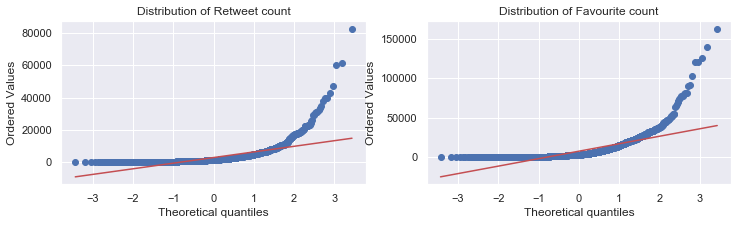

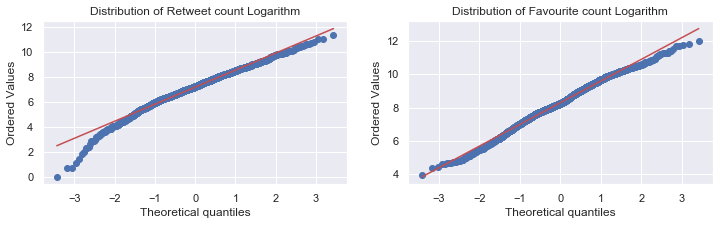

In [170]:
#distribution of retweet and favourite counts
n_rt= WRD_tweets.retweet_count
n_fav= WRD_tweets.favorite_count

fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
stats.probplot(n_rt, plot=plt) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
ax1.set_title("Distribution of Retweet count")

ax2 = fig.add_subplot(122)
stats.probplot(n_fav, plot=plt)
ax2.set_title("Distribution of Favourite count");

#calculate logarithm for non-zero counts
log_rt= np.log(WRD_tweets[WRD_tweets.retweet_count>0].retweet_count)
log_fav= np.log(WRD_tweets[WRD_tweets.favorite_count>0].favorite_count)

fig = plt.figure(figsize=(12,3))

ax3 = fig.add_subplot(121)
stats.probplot(log_rt, plot=plt)
ax3.set_title("Distribution of Retweet count Logarithm")

ax4 = fig.add_subplot(122)
stats.probplot(log_fav, plot=plt);
ax4.set_title("Distribution of Favourite count Logarithm");

The counts of favourites and of retweets are approximately log-normally distributed (though retweets, deviate somewhat at very low counts).

### Favourites and retweets are strongly correlated

Seaborn's jointplot function is a good way to look at the relationship between retweet and favourite count

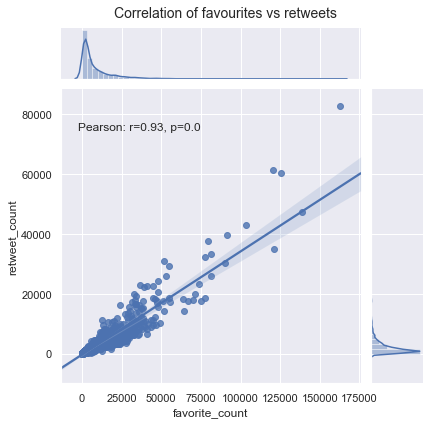

In [171]:
#only consider non-zero values
x=(WRD_tweets[(WRD_tweets.favorite_count>0) & (WRD_tweets.retweet_count>0)].favorite_count)
y=(WRD_tweets[(WRD_tweets.favorite_count>0) & (WRD_tweets.retweet_count>0)].retweet_count)

corr_coeff= stats.pearsonr(x,y) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

ax=sns.jointplot(x,y,kind="reg")
ax.fig.text(x=0.3,y=0.7, s="Pearson: r={0:.2f}, p={1:.1f}".format(corr_coeff[0],corr_coeff[1]), ha="center", va="center")
                                    #decimals https://stackoverflow.com/a/8940627
ax.fig.subplots_adjust(top=0.93) #title https://stackoverflow.com/a/29814281
ax.fig.suptitle('Correlation of favourites vs retweets', fontsize=14);



Plot the log values of retweet count and of favourite count - to reduce overplotting and get a better distribution of the counts 

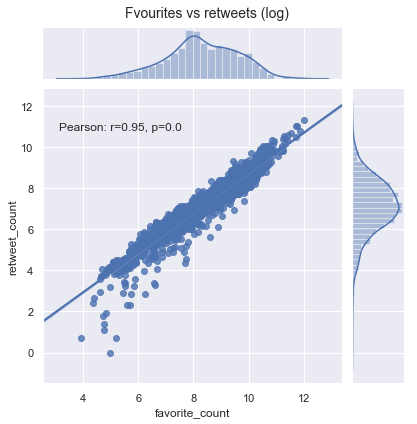

In [172]:
x=np.log(WRD_tweets[(WRD_tweets.favorite_count>0) & (WRD_tweets.retweet_count>0)].favorite_count)
y=np.log(WRD_tweets[(WRD_tweets.favorite_count>0) & (WRD_tweets.retweet_count>0)].retweet_count)

corr_coeff= stats.pearsonr(x,y)

ax=sns.jointplot(x,y,kind="reg")

ax.fig.text(x=0.3,y=0.7, s="Pearson: r={0:.2f}, p={1:.1f}".format(corr_coeff[0],corr_coeff[1]), ha="center", va="center")
ax.fig.subplots_adjust(top=0.93)
ax.fig.suptitle('Fvourites vs retweets (log)', fontsize=14);

There is a very stong correlation (r=0.93) between retweet count and favourite count. This can easily be understood as both retweets and favourite are expressions of audience engagement, the former being a stronger form of engagement. There is also a mutual re-inforcement mechanism at play, as tweets that are retweeted are shown to a wider audience, increasing the pool of tweets who may favourite the tweet ; and popular tweets, as expressed by a higher favorite count are given higher prominence in the Twitter timeline. This feedback mechanism is likely to be the basis for the log-normal distribution observed.

### The popularity of WeRateDogs increases steadily over a 20 month period

With nearly 8 million followers, @dog_rates (WeRateDogs) is a very successful Twitter account. How did it get there? 

The plot below shows the evolution of audience engagement over the first 20 months. Only original tweets are considered - i.e. replies, quote-tweets and retweets are left out, as audience engagement is fundamentally different with them. 

The retweet and favourite counts are shown for each tweet as a point in the scatter plot, on a logarithmic y-axis, with a line shown a rolling mean of a window size of 50 tweets.

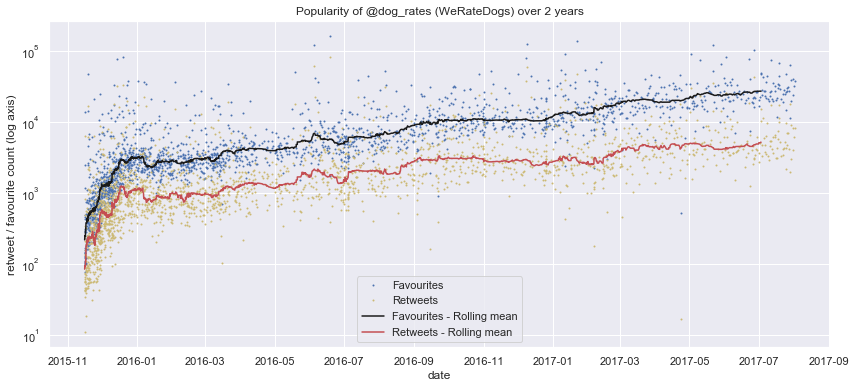

In [173]:
fig, ax = plt.subplots(figsize=(14,6))

x = WRD_tweets[WRD_tweets.tweet_type=='Original'].timestamp

y1 = WRD_tweets[WRD_tweets.tweet_type=='Original'].favorite_count
y1m = y1.rolling(50).median()

y2 = WRD_tweets[WRD_tweets.tweet_type=='Original'].retweet_count
y2m = y2.rolling(50).median()

ax.plot_date(x,y1, color='b', markersize = 1)
ax.plot_date(x,y2, color='y', markersize = 1)

ax.plot(x,y1m, color='k')
ax.plot(x,y2m,color='r')
plt.yscale("log")

ax.set_title("Popularity of @dog_rates (WeRateDogs) over 2 years")
ax.set_ylabel("retweet / favourite count (log axis)")
ax.set_xlabel("date")
ax.legend(['Favourites','Retweets','Favourites - Rolling mean','Retweets - Rolling mean']);


During the first month or two, there's a rapid increase in popularity - from tens to thousands of retweets. Thereafter, the slope of the curve become much less steep but increases steadily until the end of the period studied. The approximately linear aspect of the rolling means expresses an exponential increase since the y-axis is logarithmic. The distance between the lines for favourites and retweets is relatively consistent but widens slowly.

### Tweet popularity is associated with naming of dogs, dog "stage", and retweeting


WeRateDogs commonly states the name of the dog in the picture, as well as the "dog stage". Does this make the tweets more popular?

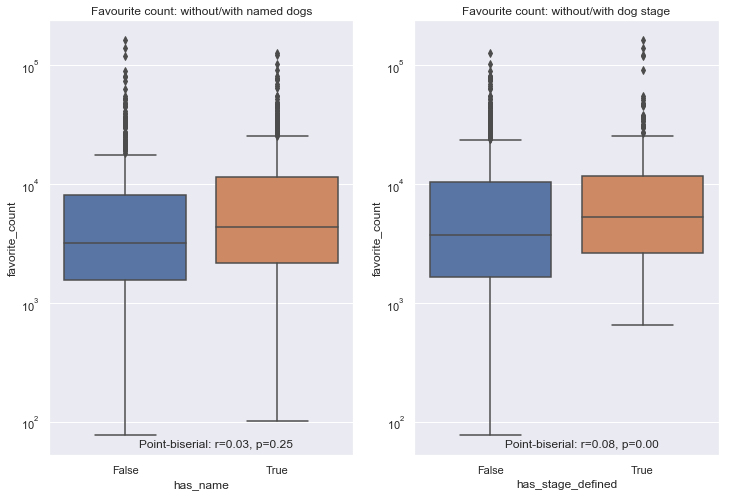

In [174]:
data = WRD_tweets[(WRD_tweets.favorite_count>0) & (WRD_tweets.tweet_type=='Original')]

#correlation https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
corr_name = stats.pointbiserialr(data.has_name,data.favorite_count)
corr_stage = stats.pointbiserialr(data.has_stage_defined,data.favorite_count)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(y='favorite_count',x='has_name',data= data,ax=ax1).set_title('Favourite count: without/with named dogs')
fig.get_axes()[0].set_yscale('log')

sns.boxplot(y='favorite_count',x='has_stage_defined',data= data,ax=ax2).set_title('Favourite count: without/with dog stage')
fig.get_axes()[1].set_yscale('log')

ax1.text(x=0.6,y=65, s="Point-biserial: r={0:.2f}, p={1:.2f}".format(corr_name[0],corr_name[1]), ha="center", va="center")
ax2.text(x=0.6,y=65, s="Point-biserial: r={0:.2f}, p={1:.2f}".format(corr_stage[0],corr_stage[1]), ha="center", va="center");

Tweets that include a named dog or mention a dog stage are more popular - however the the difference is marginal. The correlation coefficient (r=0.03) and p-value (p=0.24) suggest the difference is not significant for named dogs, and it is only slightly higher for unnamed vs named dogs (r=0.08, p=0)

Is there a discernible effect of retweeting, and of the type of tweet?

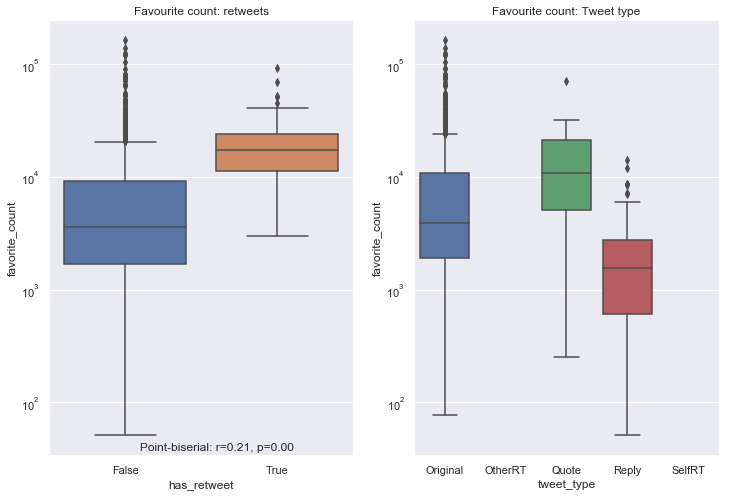

In [175]:
data = WRD_tweets[WRD_tweets.favorite_count>0]

corr_coeff = stats.pointbiserialr(data.has_retweet,data.favorite_count)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(y='favorite_count',x='has_retweet',data= data,ax=ax1).set_title('Favourite count: retweets')
fig.get_axes()[0].set_yscale('log')
ax1.text(x=0.6,y=40, s="Point-biserial: r={0:.2f}, p={1:.2f}".format(corr_coeff[0],corr_coeff[1]), ha="center", va="center")

sns.boxplot(y='favorite_count',x='tweet_type',data= data,ax=ax2).set_title('Favourite count: Tweet type')
fig.get_axes()[1].set_yscale('log')

The box-plot shows that WeRateDogs tweets which are retweeted by the same account have a higher favourite count than those that are not. Thus retweeting is plausibly a good strategy for increasing a tweets popularity.However, the analysis here can't establish causality, because it's certainly possible that popular tweets are more likely to be chosen for retweeting.

As expected replies are less popular than original WeRateDog tweets, but quote tweets are surprisingly more popular than the standard original WeRateDog tweets.

### The WeRateDogs ratings system is meaningful

WeRateDogs uses an ideosyncratic rating system for dogs, in which ratings of usually between 10 to 13 out of 10 are used. Lower rating do exist as well as 14, but ratings above 14 are outside of the standard used.

Do these ratings express anything meanful about the dog(s) in question? Below is a regression plot of the rating (numerator) against the dog's popularity (log of favorite count). Only ratings below 15/10 are considered.

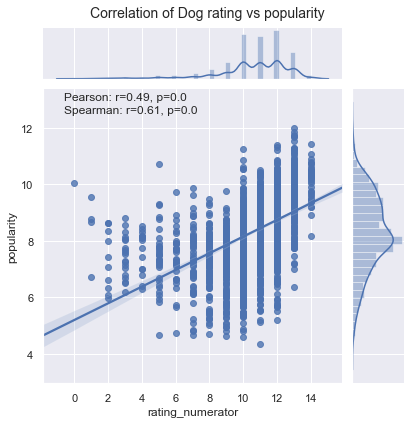

In [176]:
data = dog_predictions[dog_predictions.rating_numerator<15]

x = data.rating_numerator
y = data.popularity

pearson = stats.pearsonr(x,y)
spearman = stats.spearmanr(x,y) #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html

ax=sns.jointplot(x,y,kind="reg")
ax.fig.text(x=0.17,y=0.77, s="Pearson: r={0:.2f}, p={1:.1f}".format(pearson[0],pearson[1]), ha="left", va="center")
ax.fig.text(x=0.17,y=0.74, s="Spearman: r={0:.2f}, p={1:.1f}".format(spearman[0],spearman[1]), ha="left", va="center")

ax.fig.subplots_adjust(top=0.93)
ax.fig.suptitle('Correlation of Dog rating vs popularity', fontsize=14);


The plot suggests that the rating system is meaningful and there is in fact a relationship between the rating and the popularity of a dog. The Pearson correlation coefficient of r=0.61 is lower than the Spearman correlation coefficient r=0.61, since Pearson only measure linear relationships. Again, it is not possible to draw any conclusions re. causality here - it may be that a higher rating biases the audience to favour a dog picture, or it may be that a high/low favourite count and a high/low dog rating are both independently caused by how great a dog picture is.

### Dog stage and breed have little impact on popularity

Are young dogs more popular? Are certain breeds more popular? The box plot below looks at this question.

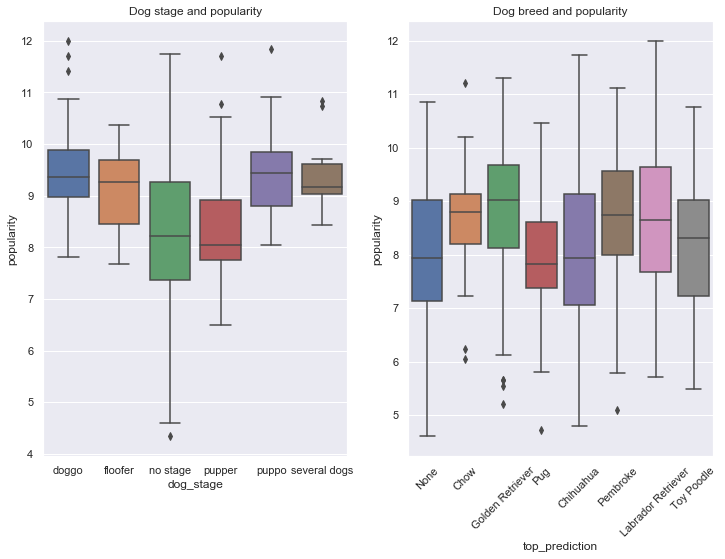

In [177]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))

data=dog_predictions
sns.boxplot(y='popularity',x='dog_stage',data = data,ax=ax1).set_title('Dog stage and popularity')

top_dogs=dog_predictions.top_prediction.value_counts().head(8).index.tolist()
data=dog_predictions[dog_predictions.top_prediction.isin(top_dogs)]

sns.boxplot(y='popularity',x='top_prediction',data = data,ax=ax2).set_title('Dog breed and popularity')
plt.xticks(rotation=45);

The most popular dog stages are "puppo", "doggo" and "floofer", whose median popularity is about one unit above that of "pupper" and photos of dogs where no 'dog stage' is mentioned. It is perhaps surprising that "pupper" has the lowest median popularity rating - this suggests that it isn't simply the fact that a dog staage is mentioned in a tweet that contributes to its popularity.

Amongst the 7 most common dog breeds, Golden Retrievers tend to be the most popular, with Pugs and Chihuahuas at the lowest median popularity - these are roughly equal with pics that have no detected dog breed, which usually do not have a dog in the photo at all.

However, the effect of dog stage and dog breed on the popularity of dog pics is relatively small, considering that the ranges overlap.

### The most common breed is Golden Retriever

Our cleaned data enable us to find out what the most common dog breeds are - here are the top 20 breeds. This analysis assumes that the breed predictions are quite accurate and don't have any systematic bias.

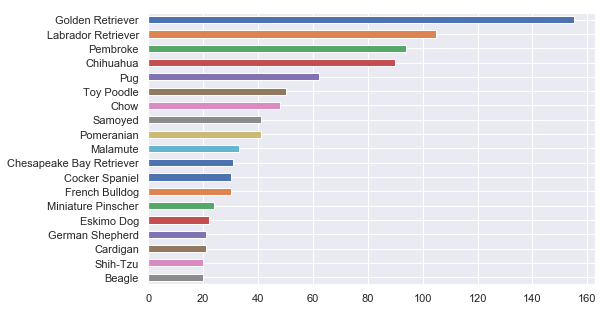

In [178]:
dog_predictions.top_prediction.value_counts()[1:20].plot.barh(figsize=(8,5))
plt.gca().invert_yaxis()

### The most common dog names Cooper, Lucy, Charlie and Oliver

Similarly, our cleaned data enable us to find out what the most common dog names are.

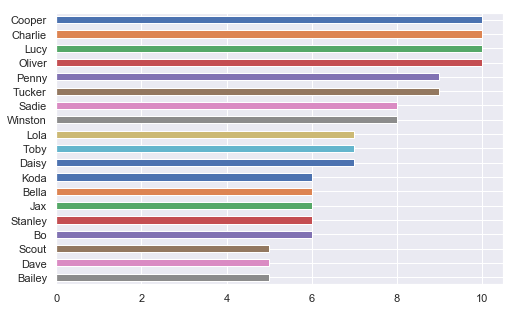

In [179]:
dog_predictions.name.value_counts()[1:20].plot.barh(figsize=(8,5))
plt.gca().invert_yaxis();

**Sources used**

A number of sources were used for this project - links are usually made available as comments

* https://seaborn.pydata.org/tutorial/regression.html
* https://seaborn.pydata.org/generated/seaborn.catplot.html
* https://developer.twitter.com/en/docs/basics/twitter-ids.html
* https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json.html
* https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
* https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
* https://pandas.pydata.org/pandas-docs/version/0.24/whatsnew/v0.24.0.html#optional-integer-na-support
* https://stackoverflow.com/a/11548224
* https://stackoverflow.com/a/18117744
* https://stackoverflow.com/a/18937252
* https://stackoverflow.com/a/19960116
* https://stackoverflow.com/a/27901076
* https://stackoverflow.com/a/29814281
* https://stackoverflow.com/a/44586034
* https://stackoverflow.com/a/49469052
* https://stackoverflow.com/a/8940627